In [176]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plts
import warnings
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
import matplotlib.cm as cm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
from AngioMorphPCA.cut_centerline import read_vtk_curve, cut_curve, interpolate_curve, write_vtk_curve
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


plt.rcParams['image.cmap'] = 'jet'  # 替换为你想要的 colormap 名称


def interpolate_to_fixed_points(sorted_curve_bs, target_points=120):
    """
    将 (n, m, 3) 形状的 3D 曲线数据插值为 (n, target_points, 3) 形状的数据。
    
    参数:
    sorted_curve_bs (ndarray): 形状为 (n, m, 3) 的 3D 曲线数据，n 是数据数量，m 是原始每条曲线的点数。
    target_points (int): 插值后的目标点数，默认值为 120。
    
    返回:
    ndarray: 形状为 (n, target_points, 3) 的 3D 插值曲线数据。
    """
    n, m, d = sorted_curve_bs.shape  # (79, 119, 3) 的形状
    interpolated_data = np.zeros((n, target_points, d))  # (n, 120, 3)
    
    for i in range(n):
        for j in range(d):  # 对每个维度 (x, y, z) 单独进行插值
            original_points = sorted_curve_bs[i, :, j]
            original_indices = np.linspace(0, 1, m)  # 原始曲线的归一化位置
            target_indices = np.linspace(0, 1, target_points)  # 目标插值的归一化位置
            interpolator = interp1d(original_indices, original_points, kind='linear')
            interpolated_data[i, :, j] = interpolator(target_indices)  # 在目标点上插值
    
    return interpolated_data

def calculate_curve_length(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线的总长度。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        float: 曲线的总长度。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)


    
    # 计算每个差值的欧氏距离，并求和

    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))

    total_length = segment_lengths.sum()
    
    return total_length

def calculate_abscissas(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线每个点的累计弧长（abscissas）。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        numpy.ndarray: 一个形状为 (n,) 的数组，包含每个点对应的累计弧长。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)
    
    # 计算每个相邻点对之间的距离
    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))
    
    # 计算累计弧长，起始点的弧长为 0
    abscissas = np.concatenate(([0], np.cumsum(segment_lengths)))
    
    return abscissas

def resample_standardized_curves(standardized_centerlines, standardized_abscissas, m):
    """
    Resample each curve in standardized_centerlines to have exactly m points.

    :param standardized_centerlines: List of (n,3) numpy arrays representing 3D curves.
    :param standardized_abscissas: List of (n,) numpy arrays representing abscissas corresponding to each curve.
    :param m: The number of points each resampled curve should have.
    :return: (new_centerlines, new_abscissas), both resampled to m points.
    """
    new_centerlines = []
    new_abscissas = []

    for i in range(len(standardized_centerlines)):
        curve = standardized_centerlines[i]  # (n,3)
        abscissas = standardized_abscissas[i]  # (n,)

        # 生成新的m个等间距 abscissas
        new_t = np.linspace(abscissas[0], abscissas[-1], m)

        # 分别对 x, y, z 进行插值
        interp_x = interp1d(abscissas, curve[:, 0], kind='cubic', fill_value="extrapolate")
        interp_y = interp1d(abscissas, curve[:, 1], kind='cubic', fill_value="extrapolate")
        interp_z = interp1d(abscissas, curve[:, 2], kind='cubic', fill_value="extrapolate")

        # 计算新的坐标
        new_x = interp_x(new_t)
        new_y = interp_y(new_t)
        new_z = interp_z(new_t)

        # 组合 x, y, z
        new_curve = np.vstack((new_x, new_y, new_z)).T  # (m, 3)

        # 存储结果
        new_centerlines.append(new_curve)
        new_abscissas.append(new_t)

    return new_centerlines, new_abscissas


def align_centerlines_procrustes(original_centerlines):
    num_curves, num_points, dim = original_centerlines.shape
    
    # 选择第一条曲线作为参考
    reference_curve = original_centerlines[0]

    aligned_centerlines = np.zeros_like(original_centerlines)

    for i in range(num_curves):
        _, aligned_curve, _ = procrustes(reference_curve, original_centerlines[i])
        aligned_centerlines[i] = aligned_curve

    return aligned_centerlines

def krzanowski_subspace_similarity(std_pca_components, non_std_pca_components, n_components=10):
    """
    应用 Krzanowski (1979) 方法计算两个 PCA 子空间的相似性。
    使用主角法 (Principal Angles) 计算两个子空间之间的夹角。

    参数:
    - std_pca_components: 标准化 PCA 载荷矩阵 (components_.T)，shape (n_features, n_components)
    - non_std_pca_components: 非标准化 PCA 载荷矩阵 (components_.T)，shape (n_features, n_components)
    - n_components: 比较的主成分个数

    返回:
    - cos_angles: 每个主角的余弦值，越接近1表示两个空间越相似
    """
    # 只取前 n_components 个主成分的载荷矩阵
    U_std = std_pca_components[:, :n_components]
    U_non_std = non_std_pca_components[:, :n_components]

    # 计算主角夹角 (以弧度为单位)
    angles = subspace_angles(U_std, U_non_std)

    # 计算主角的余弦值，越接近1表示空间越相似
    cos_angles = np.cos(angles)

    print("\n=== Krzanowski Subspace Similarity (Principal Angles) ===")
    for i, angle in enumerate(angles):
        print(f"Principal Angle {i+1}: {np.degrees(angle):.2f} degrees, cos(angle): {cos_angles[i]:.4f}")

    return cos_angles

def analyze_pca_relationship(std_pca_result, non_std_pca_result, n_components=10):
    """
    分析两个 PCA 结果之间的关系，包括：
    1. 计算各主成分的 Pearson 相关系数和 p 值。
    2. 拟合线性回归模型，得到变换矩阵 W，并绘制热图。
    3. 计算变换矩阵 W 的对角项和非对角项的绝对值总和，及其比值。

    参数:
    - std_pca_result: 标准化后的 PCA 结果 (numpy array, shape: [n_samples, n_components])
    - non_std_pca_result: 未标准化的 PCA 结果 (numpy array, shape: [n_samples, n_components])
    - n_components: 要分析的 PCA 维数 (默认为 10)

    返回:
    - W: 线性回归计算得到的变换矩阵
    - corr_results: 各主成分的 Pearson 相关系数和 p 值 (列表)
    - off_diag_ratio: 非对角项 / 对角项比值
    """

    print("\n=== PCA 相关性分析 ===")
    corr_results = []
    for i in range(n_components):
        corr, p = pearsonr(std_pca_result[:, i], non_std_pca_result[:, i])
        corr_results.append((corr, p))
        print(f"PC{i+1} 相关系数: {corr:.3f}, p值: {p:.3e}")

    print("\n=== 线性回归分析 ===")
    model = LinearRegression()
    model.fit(std_pca_result, non_std_pca_result)
    W = model.coef_

    plt.figure(figsize=(8, 6))
    sns.heatmap(W, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Linear Regression Coefficients (PCA Components 1-10)")
    plt.xlabel("Standardized PCA Components")
    plt.ylabel("Non-Standardized PCA Components")
    plt.show()

    off_diagonal_sum = np.sum(np.abs(W)) - np.sum(np.abs(np.diag(W)))
    diag_sum = np.sum(np.abs(np.diag(W)))
    off_diag_sum = np.sum(np.abs(W)) - diag_sum
    off_diag_ratio = off_diag_sum / diag_sum

    print("\n=== 变换矩阵统计信息 ===")
    print(f"变换矩阵非对角项绝对值总和: {off_diagonal_sum:.4f}")
    print(f"对角项绝对值和: {diag_sum:.4f}")
    print(f"非对角项绝对值和: {off_diag_sum:.4f}")
    print(f"非对角项 / 对角项比值: {off_diag_ratio:.4f}")

    return W, corr_results, off_diag_ratio





curve_bs = np.load("../geom_aligned_curves_88/geomstats_aligned_to_first_88.npy")
curve_cs = np.load("../geom_aligned_curves_88/geomstats_aligned_to_first_88.npy")
# curve_bs = np.load("../geom_aligned_curves_85/geomstats_aligned_to_first_85.npy")
# curve_cs = np.load("../geom_aligned_curves_85/geomstats_aligned_to_first_85.npy")


curve_bs = interpolate_to_fixed_points(curve_bs, 120)
# unaligned_curvatures = np.load("../unaligned_curvatures.npy")
files = np.load("../geom_aligned_curves_88/total_files_88.npy")[:curve_bs.shape[0]]

print ("curve_bs.shape:", curve_bs.shape)
# print (unaligned_curvatures.shape)
print ("files length:", files.shape[0])

brava_num = len(curve_bs)

original_centerlines = []
abscissas = []
original_lengths = []
curve_ds = [] # curve_ds是用original_length还原长度的curve_bs,好像难以解释它是怎么求得的
standardized_centerlines = []
standardized_abscissas = []
original_tortuosities = []
original_norms = []

m=75
for i in range(len(files)):
    # print ("files[i]:", files[i])
    original_centerline = Get_simple_vtk("../"+files[i])
    # print ("original_centerline.shape:", original_centerline.shape)
    # print (calculate_curve_length(original_centerline), calculate_curve_length(curve_bs[i]))
    original_lengths.append(calculate_curve_length(original_centerline))
    original_centerlines.append(original_centerline)
    abscissas.append(calculate_abscissas(original_centerline))
    curve_ds.append(curve_bs[i] * calculate_curve_length(original_centerline))
    original_tortuosities.append(calculate_curve_length(original_centerline)/np.linalg.norm(original_centerline[-1]-original_centerline[0]))
    original_norms.append(np.linalg.norm(original_centerline[-1]-original_centerline[0]))
print ("所有中心线的original长度的均值是",np.mean(original_lengths), "标准差是", np.std(original_lengths))

for i in range(len(files)):
    standardized_centerlines.append(original_centerlines[i]*np.mean(original_lengths)/original_lengths[i])
    standardized_abscissas.append(abscissas[i]*np.mean(original_lengths)/original_lengths[i])

resampled_standardized_centerlines, resampled_standardized_abscissas = resample_standardized_curves(standardized_centerlines, standardized_abscissas, m)

original_norms = np.array(original_norms)
original_centerlines = np.array(original_centerlines)
abscissas = np.array(abscissas)
original_lengths = np.array(original_lengths)
original_tortuosities = np.array(original_tortuosities)
curve_ds = np.array(curve_ds)
resampled_standardized_centerlines = np.array(resampled_standardized_centerlines)
resampled_standardized_abscissas = np.array(resampled_standardized_abscissas)

files_label = []
for i in range(len(files)):
    files_label.append("_".join([files[i].split('\\')[-1].split('.')[0].split('_')[0],files[i].split('\\')[-1].split('.')[0].split('_')[-1]]))

# print (files_label)

original_centerlines_copy = np.copy(original_centerlines)
resampled_standardized_centerlines_copy = np.copy(resampled_standardized_centerlines)




curve_bs.shape: (88, 120, 3)
files length: 88
所有中心线的original长度的均值是 74.93372771687922 标准差是 8.185160960582923


In [213]:
import re

# 原始表格数据，你可以直接粘贴进去
raw_data = """
BG001   24  F
BG0002  31  M
BG0003  29  M
BG04    21  M
BG05    35  F
BG06    20  F
BG07    41  F
BG08    27  F
BG09    23  F
BG10    21  F
BG11    44  F
BG12    36  F
BG13    38  M
BG15    27  M
BG17    31  M
BG18    24  M
Set 8   32  M
Set 9   46  M
BG0014  23  F
BG0019  34  M
BG0020  31  M
BG0021  33  M
BG0022  21  M
BH0003  64  F
BH0004  19  M
BH0005  28  F
BH0006  26  F
BH0008  28  M
BH0009  42  F
BH0010  26  F
BH0011  27  F
BH0012  43  M
BH0013  28  M
BH0014  23  F
BH0015  25  F
BH0016  28  M
BH0017  24  F
BH0018  21  F
BH0019  27  F
BH0020  21  M
BH0021  33  F
BH0022  47  F
BH0023  19  F
BH0024  22  M
BH0025  24  M
BH0026  37  F
BH0027  46  F
BH0029  46  M
BH0030  33  F
BH0031  24  F
BH0032  48  M
BH0033  59  M
BH0034  27  F
BH0035  24  F
BH0036  29  F
BH0037  50  F
BH0038  22  F
BH0039  42  F
BH0040  30  F
BI0001  22  M
BH0002  25  F
"""

# 解析数据成字典
age_sex_dict = {}

for line in raw_data.strip().splitlines():
    parts = line.split()
    code, age, sex = parts[0], int(parts[1]), parts[2]

    # 处理BG001 -> BG0001 这种情况
    match = re.match(r"(BG|BH|BI)(\d+)", code)
    if match:
        prefix, number = match.groups()
        code = f"{prefix}{int(number):04d}"  # 转成4位数字格式，比如 BG001 -> BG0001

    age_sex_dict[code] = {"AGE": age, "SEX": sex}

print(age_sex_dict)


{'BG0001': {'AGE': 24, 'SEX': 'F'}, 'BG0002': {'AGE': 31, 'SEX': 'M'}, 'BG0003': {'AGE': 29, 'SEX': 'M'}, 'BG0004': {'AGE': 21, 'SEX': 'M'}, 'BG0005': {'AGE': 35, 'SEX': 'F'}, 'BG0006': {'AGE': 20, 'SEX': 'F'}, 'BG0007': {'AGE': 41, 'SEX': 'F'}, 'BG0008': {'AGE': 27, 'SEX': 'F'}, 'BG0009': {'AGE': 23, 'SEX': 'F'}, 'BG0010': {'AGE': 21, 'SEX': 'F'}, 'BG0011': {'AGE': 44, 'SEX': 'F'}, 'BG0012': {'AGE': 36, 'SEX': 'F'}, 'BG0013': {'AGE': 38, 'SEX': 'M'}, 'BG0015': {'AGE': 27, 'SEX': 'M'}, 'BG0017': {'AGE': 31, 'SEX': 'M'}, 'BG0018': {'AGE': 24, 'SEX': 'M'}, 'Set': {'AGE': 9, 'SEX': '46'}, 'BG0014': {'AGE': 23, 'SEX': 'F'}, 'BG0019': {'AGE': 34, 'SEX': 'M'}, 'BG0020': {'AGE': 31, 'SEX': 'M'}, 'BG0021': {'AGE': 33, 'SEX': 'M'}, 'BG0022': {'AGE': 21, 'SEX': 'M'}, 'BH0003': {'AGE': 64, 'SEX': 'F'}, 'BH0004': {'AGE': 19, 'SEX': 'M'}, 'BH0005': {'AGE': 28, 'SEX': 'F'}, 'BH0006': {'AGE': 26, 'SEX': 'F'}, 'BH0008': {'AGE': 28, 'SEX': 'M'}, 'BH0009': {'AGE': 42, 'SEX': 'F'}, 'BH0010': {'AGE': 26, 

In [214]:
import re

# 提取tag的函数：假设tag是第一个下划线或“_reverse”之前的部分
def extract_tag(file):
    match = re.search(r'\\([^\\_]+)', file)
    return match.group(1) if match else None

# 计算索引匹配列表的函数
def compute_pair_indices(files):
    tags = [extract_tag(f) for f in files]

    index_map = {}
    for i, tag in enumerate(tags):
        if tag in index_map:
            index_map[tag].append(i)
        else:
            index_map[tag] = [i]

    result = [-1] * len(files)
    for indices in index_map.values():
        if len(indices) == 2:
            result[indices[0]] = indices[1]
            result[indices[1]] = indices[0]

    return result

def get_pair_indices(files):
    tags = [extract_tag(f) for f in files]

    index_map = {}
    for i, tag in enumerate(tags):
        if tag in index_map:
            index_map[tag].append(i)
        else:
            index_map[tag] = [i]

    result_list = []
    for tag, indices in index_map.items():
        if len(indices) == 1:
            result_list.append([tag, indices[0], -1])
        elif len(indices) == 2:
            result_list.append([tag, indices[0], indices[1]])

    result_df = pd.DataFrame(result_list, columns=['tag', 'idx_1', 'idx_2'])
    result_dict = {row['tag']: (row['idx_1'], row['idx_2']) for _, row in result_df.iterrows()}

    return result_list, result_df, result_dict

# 示例用法

paring_result = compute_pair_indices(files)
print(paring_result)
pairing_result_list, pairing_result_df, pairing_result_dict = get_pair_indices(files)
import numpy as np
import pandas as pd
import itertools

def compute_relative_difference(val1, val2):
    return abs(val1 - val2) / ((val1 + val2) / 2)

def analyze_similarity(result_dict, original_lengths, original_tortuosities):
    # 计算相同tag下的相对差异
    paired_length_diff = []
    paired_tortuosity_diff = []

    for tag, (idx1, idx2) in result_dict.items():
        if idx2 == -1:
            continue
        l1, l2 = original_lengths[idx1], original_lengths[idx2]
        t1, t2 = original_tortuosities[idx1], original_tortuosities[idx2]

        paired_length_diff.append(compute_relative_difference(l1, l2))
        paired_tortuosity_diff.append(compute_relative_difference(t1, t2))

    # 计算随机任意两条曲线的相对差异
    all_length_diff = []
    all_tortuosity_diff = []

    indices = list(range(len(original_lengths)))
    for idx1, idx2 in itertools.combinations(indices, 2):
        l1, l2 = original_lengths[idx1], original_lengths[idx2]
        t1, t2 = original_tortuosities[idx1], original_tortuosities[idx2]

        all_length_diff.append(compute_relative_difference(l1, l2))
        all_tortuosity_diff.append(compute_relative_difference(t1, t2))

    # 转换为numpy数组以便计算统计信息
    paired_length_diff = np.array(paired_length_diff)
    paired_tortuosity_diff = np.array(paired_tortuosity_diff)
    all_length_diff = np.array(all_length_diff)
    all_tortuosity_diff = np.array(all_tortuosity_diff)

    # 统计信息
    stats = {
        'paired_length_mean': paired_length_diff.mean(),
        'paired_length_median': np.median(paired_length_diff),
        'paired_length_std': paired_length_diff.std(),

        'all_length_mean': all_length_diff.mean(),
        'all_length_median': np.median(all_length_diff),
        'all_length_std': all_length_diff.std(),

        'paired_tortuosity_mean': paired_tortuosity_diff.mean(),
        'paired_tortuosity_median': np.median(paired_tortuosity_diff),
        'paired_tortuosity_std': paired_tortuosity_diff.std(),

        'all_tortuosity_mean': all_tortuosity_diff.mean(),
        'all_tortuosity_median': np.median(all_tortuosity_diff),
        'all_tortuosity_std': all_tortuosity_diff.std(),
    }

    return stats, paired_length_diff, paired_tortuosity_diff, all_length_diff, all_tortuosity_diff


stats, paired_length_diff, paired_tortuosity_diff, all_length_diff, all_tortuosity_diff = analyze_similarity(
    pairing_result_dict, original_lengths, original_tortuosities)

pd.DataFrame([stats])


merged_result = {}

for tag, indices in result_dict.items():
    age_sex_info = age_sex_dict.get(tag, {'AGE': None, 'SEX': None})
    merged_result[tag] = {
        'indices': indices,
        'AGE': age_sex_info['AGE'],
        'SEX': age_sex_info['SEX']
    }

print(merged_result)


for tag, info in merged_result.items():
    idx1, idx2 = info['indices']
    age = info['AGE']
    sex = info['SEX']
    print(f"Tag: {tag}, Index1: {idx1}, Index2: {idx2}, Age: {age}, Sex: {sex}")

[1, 0, 3, 2, 5, 4, 7, 6, 9, 8, 11, 10, 13, 12, 15, 14, 17, 16, 19, 18, 21, 20, 23, 22, 25, 24, -1, -1, -1, 30, 29, 32, 31, 34, 33, 36, 35, 38, 37, 40, 39, 42, 41, 44, 43, 46, 45, 48, 47, 50, 49, 52, 51, 81, -1, 56, 55, -1, 59, 58, 61, 60, 63, 62, 65, 64, 67, 66, 69, 68, -1, 72, 71, 74, 73, -1, 77, 76, 79, 78, -1, 53, 83, 82, 85, 84, 87, 86]
{'BG0001': {'indices': (0, 1), 'AGE': 24, 'SEX': 'F'}, 'BG0004': {'indices': (2, 3), 'AGE': 21, 'SEX': 'M'}, 'BG0006': {'indices': (4, 5), 'AGE': 20, 'SEX': 'F'}, 'BG0007': {'indices': (6, 7), 'AGE': 41, 'SEX': 'F'}, 'BG0008': {'indices': (8, 9), 'AGE': 27, 'SEX': 'F'}, 'BG0009': {'indices': (10, 11), 'AGE': 23, 'SEX': 'F'}, 'BG0010': {'indices': (12, 13), 'AGE': 21, 'SEX': 'F'}, 'BG0011': {'indices': (14, 15), 'AGE': 44, 'SEX': 'F'}, 'BG0012': {'indices': (16, 17), 'AGE': 36, 'SEX': 'F'}, 'BG0017': {'indices': (18, 19), 'AGE': 31, 'SEX': 'M'}, 'BG0018': {'indices': (20, 21), 'AGE': 24, 'SEX': 'M'}, 'BG0019': {'indices': (22, 23), 'AGE': 34, 'SEX': 

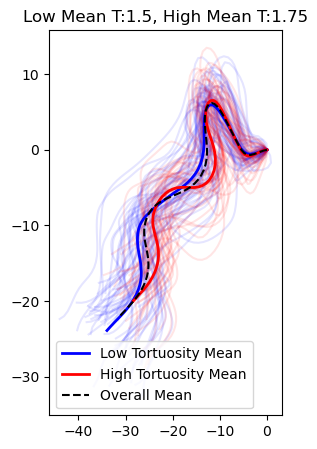

In [177]:
low_tortuosity_standardized_centerlines = resampled_standardized_centerlines[original_tortuosities < 1.8]
high_tortuosity_standardized_centerlines = resampled_standardized_centerlines[original_tortuosities > 1.8]

low_tortuosity_standardized_mean = np.mean(low_tortuosity_standardized_centerlines, axis=0)
high_tortuosity_standardized_mean = np.mean(high_tortuosity_standardized_centerlines, axis=0)

low_t_standardized_mean_tortuosity = calculate_curve_length(low_tortuosity_standardized_mean)/np.linalg.norm(low_tortuosity_standardized_mean[-1]-low_tortuosity_standardized_mean[0])
high_t_standardized_mean_tortuosity = calculate_curve_length(high_tortuosity_standardized_mean)/np.linalg.norm(high_tortuosity_standardized_mean[-1]-high_tortuosity_standardized_mean[0])

# 分别画出两类曲线
plt.figure(figsize=(3,5),dpi=100)

for curve in low_tortuosity_standardized_centerlines:
    plt.plot(curve[:, 1], -curve[:, 2], c='b', alpha=0.1)
for curve in high_tortuosity_standardized_centerlines:
    plt.plot(curve[:, 1], -curve[:, 2], c='r', alpha=0.1)

plt.plot(low_tortuosity_standardized_mean[:, 1], -low_tortuosity_standardized_mean[:, 2], c='b', label="Low Tortuosity Mean",linewidth=2)
plt.plot(high_tortuosity_standardized_mean[:, 1], -high_tortuosity_standardized_mean[:, 2], c='r', label="High Tortuosity Mean",linewidth=2)
plt.plot(np.mean(resampled_standardized_centerlines, axis=0)[:, 1], 
         -np.mean(resampled_standardized_centerlines, axis=0)[:, 2], 
         c='k', 
         label="Overall Mean",
         linestyle='--')
plt.title("Low Mean T:{}, High Mean T:{}".format(round(low_t_standardized_mean_tortuosity,2), round(high_t_standardized_mean_tortuosity,2)))
plt.legend()
plt.show()


mean_estimate_tortuosity: 1.5848965786849918
mean_estimate.shape: (120, 3)
curve_bs.shape: (88, 120, 3)


<Figure size 600x200 with 0 Axes>

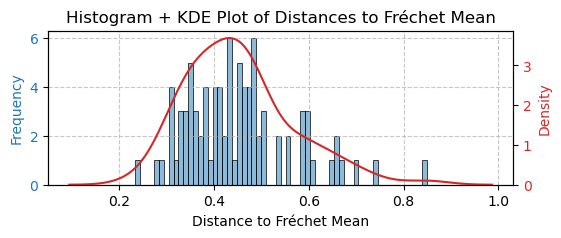

<Figure size 600x200 with 0 Axes>

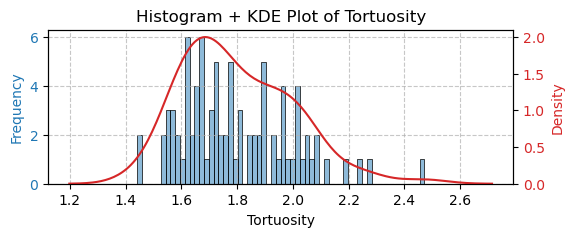

<Figure size 600x200 with 0 Axes>

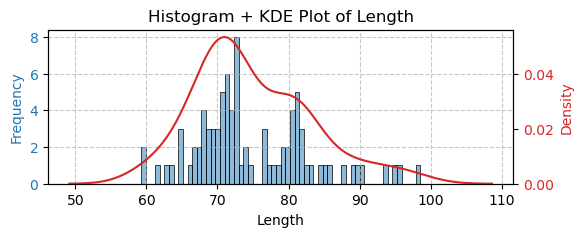

<Figure size 600x200 with 0 Axes>

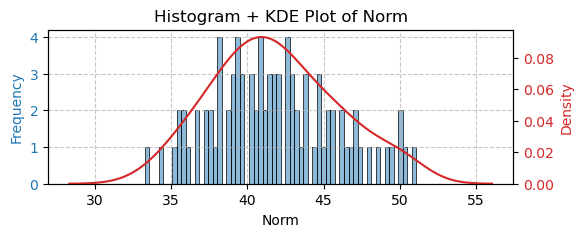

In [178]:
k_sampling_points = 121

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=True
)

curves_r3.equip_with_metric(SRVMetric)
curves_r3.equip_with_group_action(("rotations", "reparametrizations"))
curves_r3.equip_with_quotient()
mean = FrechetMean(curves_r3)
mean.fit(curve_cs)

mean_estimate = mean.estimate_
tangent_base = mean.estimate_

mean_estimate_tortuosity = calculate_curve_length(mean_estimate)/np.linalg.norm(mean_estimate[-1]-mean_estimate[0])
print ("mean_estimate_tortuosity:", mean_estimate_tortuosity)


print ("mean_estimate.shape:", mean_estimate.shape) # mean_estimate.shape: (120, 3)
print ("curve_bs.shape:", curve_cs.shape) # curve_bs.shape: (79, 120, 3)
g_dist_to_frechet = []
for i in range(len(curve_cs)):
    g_dist_to_frechet.append(curves_r3.metric.dist(mean_estimate, curve_cs[i]))
g_dist_to_frechet = np.array(g_dist_to_frechet)


bins = 60
plt.figure(figsize=(6, 2))
fig, ax1 = plt.subplots(figsize=(6, 2))

# 直方图（频数）
sns.histplot(g_dist_to_frechet, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
ax1.set_xlabel("Distance to Fréchet Mean")
ax1.set_ylabel("Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# KDE曲线（密度）- 第二个y轴
ax2 = ax1.twinx()
sns.kdeplot(g_dist_to_frechet, ax=ax2, color='tab:red')
ax2.set_ylabel("Density", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(linestyle='--', alpha=0.7)
plt.title("Histogram + KDE Plot of Distances to Fréchet Mean")
plt.show()

plt.figure(figsize=(6, 2))
fig, ax1 = plt.subplots(figsize=(6, 2))

sns.histplot(original_tortuosities, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
ax1.set_xlabel("Tortuosity")
ax1.set_ylabel("Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
sns.kdeplot(original_tortuosities, ax=ax2, color='tab:red')
ax2.set_ylabel("Density", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(linestyle='--', alpha=0.7)
plt.title("Histogram + KDE Plot of Tortuosity")
plt.show()

plt.figure(figsize=(6, 2))
fig, ax1 = plt.subplots(figsize=(6, 2))

sns.histplot(original_lengths, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
ax1.set_xlabel("Length")
ax1.set_ylabel("Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
sns.kdeplot(original_lengths, ax=ax2, color='tab:red')
ax2.set_ylabel("Density", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(linestyle='--', alpha=0.7)
plt.title("Histogram + KDE Plot of Length")
plt.show()


plt.figure(figsize=(6, 2))
fig, ax1 = plt.subplots(figsize=(6, 2))

sns.histplot(original_norms, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
ax1.set_xlabel("Norm")
ax1.set_ylabel("Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
sns.kdeplot(original_norms, ax=ax2, color='tab:red')
ax2.set_ylabel("Density", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(linestyle='--', alpha=0.7)
plt.title("Histogram + KDE Plot of Norm")
plt.show()



=======GMM========


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Length BIC: 632.5775290765918
Tortuosity BIC: -24.368782552702385


c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


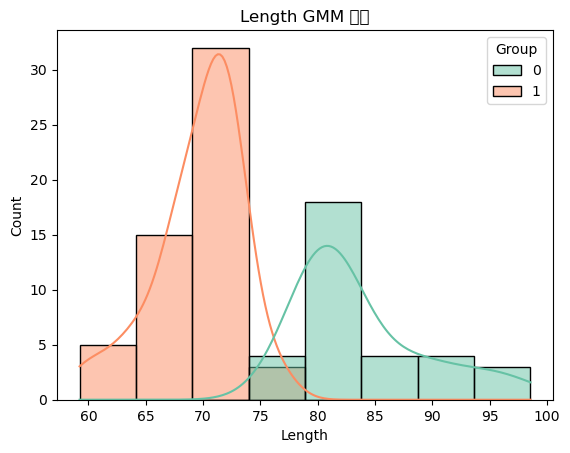

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


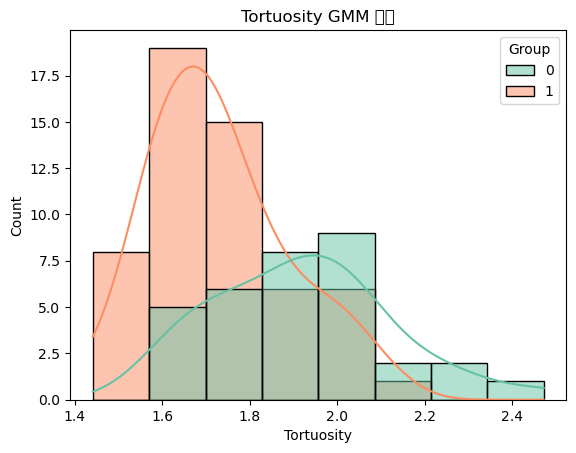

d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


=======GMM========
Low Length Group Norm Mean: 43.95738007662347
High Length Group Norm Mean: 40.53090263319371
T-test: t = 4.007, p = 0.000


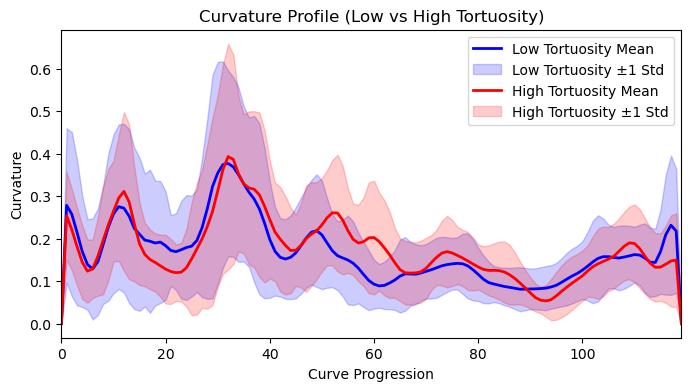

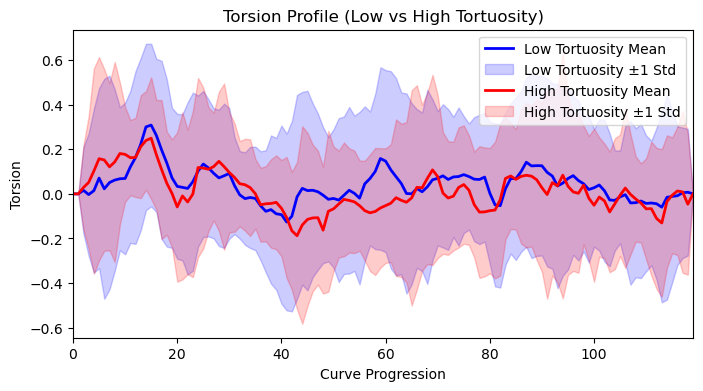

In [179]:
print ("=======GMM========")
from sklearn.mixture import GaussianMixture

# Length 双峰验证
gmm_length = GaussianMixture(n_components=2, random_state=0)
gmm_length.fit(original_lengths.reshape(-1, 1))
length_labels = gmm_length.predict(original_lengths.reshape(-1, 1))

# Tortuosity 双峰验证
gmm_tortuosity = GaussianMixture(n_components=2, random_state=0)
gmm_tortuosity.fit(original_tortuosities.reshape(-1, 1))
tortuosity_labels = gmm_tortuosity.predict(original_tortuosities.reshape(-1, 1))

print("Length BIC:", gmm_length.bic(original_lengths.reshape(-1, 1)))
print("Tortuosity BIC:", gmm_tortuosity.bic(original_tortuosities.reshape(-1, 1)))


df = pd.DataFrame({
    'Length': original_lengths,
    'Group': length_labels
})
df['Tortuosity'] = original_tortuosities

sns.histplot(data=df, x='Length', kde=True, hue='Group', palette='Set2')
plt.title("Length GMM 分组")
plt.show()

sns.histplot(data=df, x='Tortuosity', kde=True, hue='Group', palette='Set2')
plt.title("Tortuosity GMM 分组")
plt.show()


print ("=======GMM========")


low_group_norms = original_norms[length_labels == 0]
high_group_norms = original_norms[length_labels == 1]

print("Low Length Group Norm Mean:", np.mean(low_group_norms))
print("High Length Group Norm Mean:", np.mean(high_group_norms))

from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(low_group_norms, high_group_norms, equal_var=False)
print(f"T-test: t = {t_stat:.3f}, p = {p_value:.3f}")




# 因为1.8似乎是hist上的一个坑
low_c = []
high_c = []
low_t = []
high_t = []

for i in range(len(original_centerlines_copy)):
    c,t = compute_curvature_and_torsion(original_centerlines_copy[i])
    if i in indices:
        high_c.append(c)
        high_t.append(t)
    else:
        low_c.append(c)
        low_t.append(t)

# 假设low_c 和 high_c 已经计算完成，形状均为 (n_curves, n_points_per_curve)
low_c = np.array(low_c)
high_c = np.array(high_c)
low_t = np.array(low_t)
high_t = np.array(high_t)

# 计算每类曲线的均值和标准差
low_c_mean = np.mean(low_c, axis=0)
low_c_std = np.std(low_c, axis=0)
low_t_mean = np.mean(low_t, axis=0)
low_t_std = np.std(low_t, axis=0)

high_c_mean = np.mean(high_c, axis=0)
high_c_std = np.std(high_c, axis=0)
high_t_mean = np.mean(high_t, axis=0)
high_t_std = np.std(high_t, axis=0)

# 绘图
plt.figure(figsize=(8, 4))

# 绘制 Low Tortuosity
plt.plot(low_c_mean, color='b', label='Low Tortuosity Mean', linewidth=2)
plt.fill_between(range(len(low_c_mean)),
                 low_c_mean - low_c_std,
                 low_c_mean + low_c_std,
                 color='b', alpha=0.2, label='Low Tortuosity ±1 Std')

# 绘制 High Tortuosity
plt.plot(high_c_mean, color='r', label='High Tortuosity Mean', linewidth=2)
plt.fill_between(range(len(high_c_mean)),
                 high_c_mean - high_c_std,
                 high_c_mean + high_c_std,
                 color='r', alpha=0.2, label='High Tortuosity ±1 Std')

plt.xlabel("Curve Progression")
plt.ylabel("Curvature")
plt.title("Curvature Profile (Low vs High Tortuosity)")
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

# 绘图
plt.figure(figsize=(8, 4))

# 绘制 Low Tortuosity
plt.plot(low_t_mean, color='b', label='Low Tortuosity Mean', linewidth=2)
plt.fill_between(range(len(low_t_mean)),
                 low_t_mean - low_t_std,
                 low_t_mean + low_t_std,
                 color='b', alpha=0.2, label='Low Tortuosity ±1 Std')

# 绘制 High Tortuosity
plt.plot(high_t_mean, color='r', label='High Tortuosity Mean', linewidth=2)
plt.fill_between(range(len(high_t_mean)),
                 high_t_mean - high_t_std,
                 high_t_mean + high_t_std,
                 color='r', alpha=0.2, label='High Tortuosity ±1 Std')

plt.xlabel("Curve Progression")
plt.ylabel("Torsion")
plt.autoscale(enable=True, axis='x', tight=True)
plt.title("Torsion Profile (Low vs High Tortuosity)")
plt.legend()
plt.show()


In [180]:
from sklearn.mixture import GaussianMixture
import numpy as np

# GMM拟合Tortuosity的双峰分布
gmm_tortuosity = GaussianMixture(n_components=2, random_state=0)
gmm_tortuosity.fit(original_tortuosities.reshape(-1, 1))

# 每条曲线属于哪个类别 (0 或 1)
tortuosity_labels = gmm_tortuosity.predict(original_tortuosities.reshape(-1, 1))

# 也可以得到属于每个类的概率，部分数据可能是“边缘情况”
tortuosity_probs = gmm_tortuosity.predict_proba(original_tortuosities.reshape(-1, 1))

print("类别0的均值:", gmm_tortuosity.means_[0])
print("类别1的均值:", gmm_tortuosity.means_[1])

low_length = original_lengths[tortuosity_labels == 0]
high_length = original_lengths[tortuosity_labels == 1]

print(f"低 Tortuosity 类别长度均值: {low_length.mean():.2f}, 标准差: {low_length.std():.2f}")
print(f"高 Tortuosity 类别长度均值: {high_length.mean():.2f}, 标准差: {high_length.std():.2f}")

low_length_mean = low_length.mean()
low_length_std = low_length.std()

high_length_mean = high_length.mean()
high_length_std = high_length.std()

# 保存异常的曲线索引和预期长度范围
suspected_indices = []
estimated_length_range = []

for i in range(len(original_lengths)):
    length = original_lengths[i]
    tortuosity_class = tortuosity_labels[i]

    if tortuosity_class == 0:  # 属于低 Tortuosity 类
        expected_range = (low_length_mean - 2 * low_length_std, low_length_mean + 2 * low_length_std)
    else:  # 属于高 Tortuosity 类
        expected_range = (high_length_mean - 2 * high_length_std, high_length_mean + 2 * high_length_std)

    # 如果长度超出期望范围，则认为可能测错
    if length < expected_range[0] or length > expected_range[1]:
        suspected_indices.append(i)
        estimated_length_range.append(expected_range)

print("疑似异常曲线索引:", suspected_indices)
for idx, (low, high) in zip(suspected_indices, estimated_length_range):
    print(f"曲线 {idx} {files[idx]} 长度为 {original_lengths[idx]:.2f}，预期长度范围 [{low:.2f}, {high:.2f}]")

borderline_indices = np.where(np.max(tortuosity_probs, axis=1) < 0.6)[0]
print("Tortuosity 模糊边界曲线索引:", borderline_indices, files[borderline_indices])




类别0的均值: [1.95875719]
类别1的均值: [1.66755891]
低 Tortuosity 类别长度均值: 80.04, 标准差: 8.04
高 Tortuosity 类别长度均值: 71.23, 标准差: 6.01
疑似异常曲线索引: [25, 43]
曲线 25 brava_cut_mirrored\BG0020_ICA_R.vtk 长度为 84.83，预期长度范围 [59.21, 83.25]
曲线 43 brava_cut_mirrored\BH0016_ICA_L.vtk 长度为 98.56，预期长度范围 [63.96, 96.12]
Tortuosity 模糊边界曲线索引: [48 60 86] ['brava_cut_mirrored\\BH0018_ICA_R.vtk'
 'brava_cut_mirrored\\BH0029_ICA_L.vtk'
 '250216tuika\\BH0037_L_reverse_MirroredV2.vtk']


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


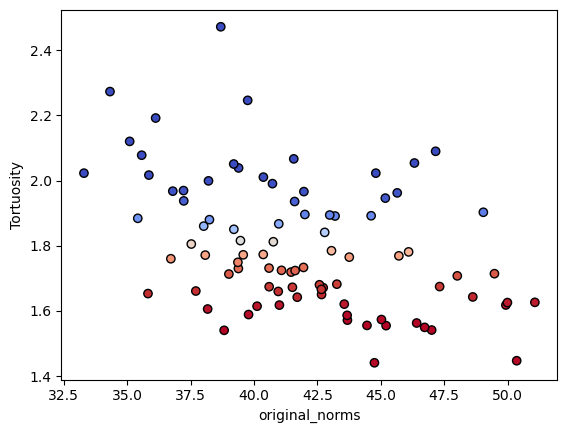

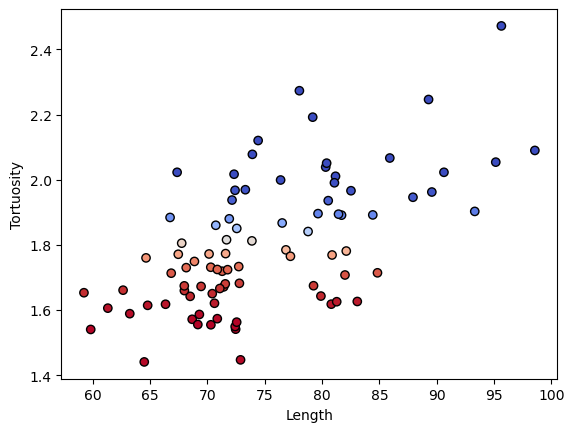

original_norms vs Tortuosity 相关系数: -0.436, p值: 2.153e-05
Length vs Tortuosity 相关系数: 0.602, p值: 5.369e-10
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4007.
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           7.79e-85
Time:                        19:26:50   Log-Likelihood:                 218.65
No. Observations:                  88   AIC:                            -431.3
Df Residuals:                      85   BIC:                            -423.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [181]:
plt.scatter(original_norms, original_tortuosities, c=tortuosity_probs[:,1], cmap='coolwarm', edgecolors='k')
plt.xlabel("original_norms")
plt.ylabel("Tortuosity")
plt.show()

plt.scatter(original_lengths, original_tortuosities, c=tortuosity_probs[:,1], cmap='coolwarm', edgecolors='k')
plt.xlabel("Length")
plt.ylabel("Tortuosity")
plt.show()

from scipy.stats import pearsonr

# 计算 original_norms 和 original_tortuosities 之间的相关系数
corr_norm_tort, p_value_norm = pearsonr(original_norms, original_tortuosities)
print(f"original_norms vs Tortuosity 相关系数: {corr_norm_tort:.3f}, p值: {p_value_norm:.3e}")

# 计算 original_lengths 和 original_tortuosities 之间的相关系数
corr_length_tort, p_value_length = pearsonr(original_lengths, original_tortuosities)
print(f"Length vs Tortuosity 相关系数: {corr_length_tort:.3f}, p值: {p_value_length:.3e}")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(np.column_stack([original_lengths, original_norms]))
X_scaled = sm.add_constant(X_scaled)
y = original_tortuosities

model_scaled = sm.OLS(y, X_scaled).fit()
print(model_scaled.summary())



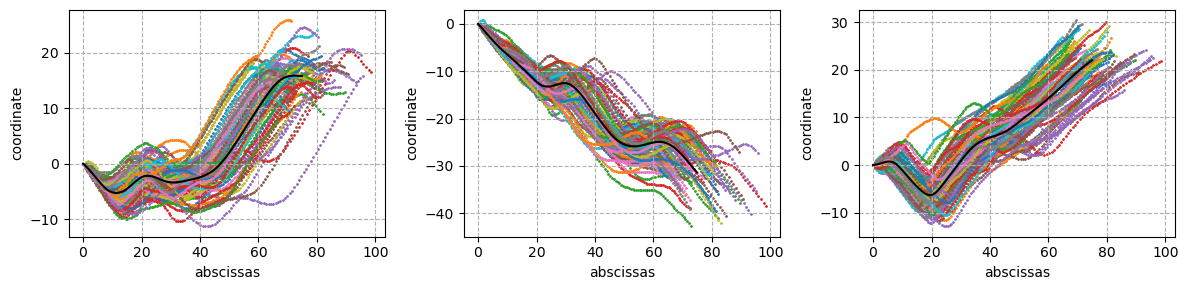

original_centerlines shape: (88, 120, 3)
abscissas shape: (88, 120)


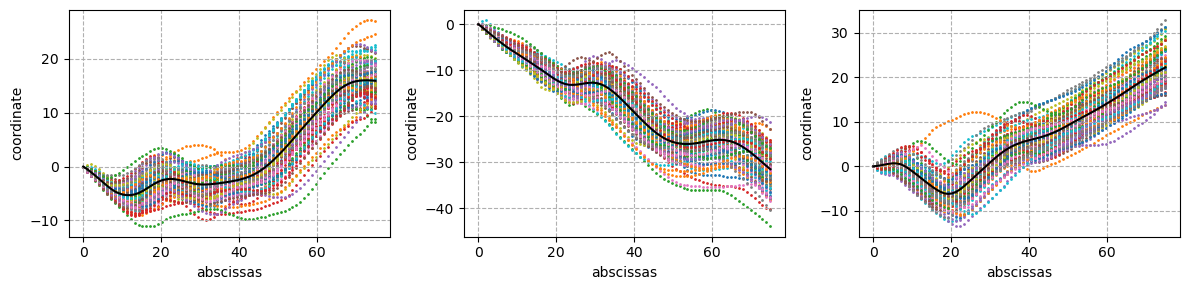

original_centerlines shape: (88, 75, 3)
abscissas shape: (88, 75)


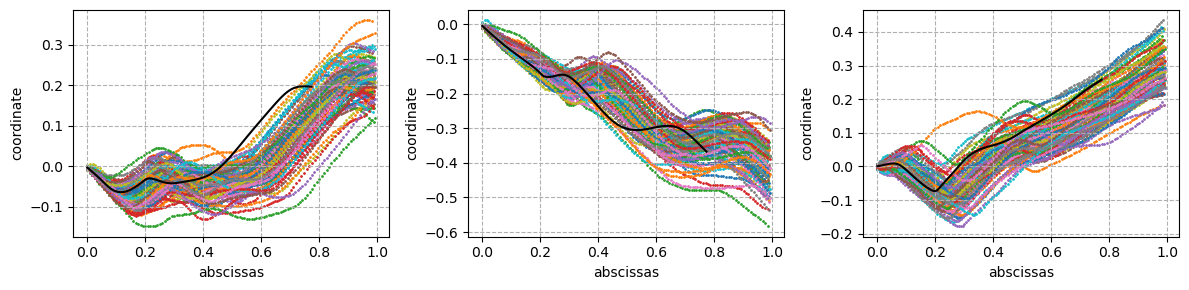

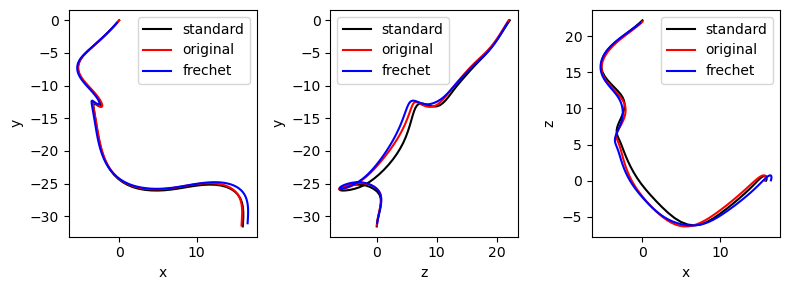

length of resampled_standardized_mean_cl: 65.69323485155365
length of original_mean_cl: 66.1268895178694
length of frechet mean shape: 65.31927550379855
tortuosity of resampled standardized mean curve:
1.5735688164245851
tortuosity of original mean curve:
1.5945059012690193
tortuosity of frechet mean curve:
1.5848965786849918


In [182]:
fig = plt.figure(figsize=(12,3), dpi=100)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
original_mean_cl = np.mean(original_centerlines_copy, axis=0)
original_mean_abscissas = np.mean(abscissas, axis=0)
ax1.plot(original_mean_abscissas,original_mean_cl[:,0],color='k')
ax2.plot(original_mean_abscissas,original_mean_cl[:,1],color='k')
ax3.plot(original_mean_abscissas,original_mean_cl[:,2],color='k')
for i in range(len(original_centerlines)):
    ax1.scatter(abscissas[i],original_centerlines_copy[i][:,0],marker='o',s=1)
    ax2.scatter(abscissas[i],original_centerlines_copy[i][:,1],marker='o',s=1)
    ax3.scatter(abscissas[i],original_centerlines_copy[i][:,2],marker='o',s=1)

for  ax in [ax1, ax2, ax3]:
    ax.set_xlabel("abscissas")
    ax.set_ylabel("coordinate")
    ax.grid(linestyle="--")
plt.tight_layout()
plt.show()

print ("original_centerlines shape:", original_centerlines_copy.shape)
print ("abscissas shape:", abscissas.shape)

# 插值到1mm/point,缩放

fig = plt.figure(figsize=(12,3), dpi=100)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
resampled_standardized_mean_cl = np.mean(resampled_standardized_centerlines_copy, axis=0)
resampled_standardized_mean_abscissas = np.mean(resampled_standardized_abscissas, axis=0)

for i in range(len(original_centerlines)):
    ax1.scatter(resampled_standardized_abscissas[i],resampled_standardized_centerlines_copy[i][:,0],marker='o',s=1)
    ax2.scatter(resampled_standardized_abscissas[i],resampled_standardized_centerlines_copy[i][:,1],marker='o',s=1)
    ax3.scatter(resampled_standardized_abscissas[i],resampled_standardized_centerlines_copy[i][:,2],marker='o',s=1)

for  ax in [ax1, ax2, ax3]:
    ax.set_xlabel("abscissas")
    ax.set_ylabel("coordinate")
    ax.grid(linestyle="--")
ax1.plot(resampled_standardized_mean_abscissas,resampled_standardized_mean_cl[:,0],color='k')
ax2.plot(resampled_standardized_mean_abscissas,resampled_standardized_mean_cl[:,1],color='k')
ax3.plot(resampled_standardized_mean_abscissas,resampled_standardized_mean_cl[:,2],color='k')

plt.tight_layout()
plt.show()

print ("original_centerlines shape:", resampled_standardized_centerlines.shape)
print ("abscissas shape:", resampled_standardized_abscissas.shape)

fig = plt.figure(figsize=(12,3), dpi=100)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

mean_estimate_abscissas = calculate_abscissas(mean_estimate)
curve_cs_abscissas = []
for i in range(len(curve_cs)):
    curve_cs_abscissas.append(calculate_abscissas(curve_cs[i]))
curve_cs_abscissas = np.array(curve_cs_abscissas)
ax1.plot(mean_estimate_abscissas,mean_estimate[:,0],color='k')
ax2.plot(mean_estimate_abscissas,mean_estimate[:,1],color='k')
ax3.plot(mean_estimate_abscissas,mean_estimate[:,2],color='k')
for i in range(len(curve_cs)):
    ax1.scatter(curve_cs_abscissas[i],curve_cs[i][:,0],marker='o',s=1)
    ax2.scatter(curve_cs_abscissas[i],curve_cs[i][:,1],marker='o',s=1)
    ax3.scatter(curve_cs_abscissas[i],curve_cs[i][:,2],marker='o',s=1)

for  ax in [ax1, ax2, ax3]:
    ax.set_xlabel("abscissas")
    ax.set_ylabel("coordinate")
    ax.grid(linestyle="--")

plt.tight_layout()
plt.show()

adjust_mean_k =84.5

fig = plt.figure(figsize=(8,3), dpi=100)
ax1 = fig.add_subplot(131)
ax1.plot(resampled_standardized_mean_cl[:,0],resampled_standardized_mean_cl[:,1],color='k',label='standard')
ax1.plot(original_mean_cl[:,0],original_mean_cl[:,1],color='r',label='original')
ax1.plot(mean_estimate[:,0]*adjust_mean_k,mean_estimate[:,1]*adjust_mean_k,color='b',label='frechet')
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2 = fig.add_subplot(132)
ax2.plot(resampled_standardized_mean_cl[:,2][::-1],resampled_standardized_mean_cl[:,1],color='k',label='standard')
ax2.plot(original_mean_cl[:,2][::-1],original_mean_cl[:,1],color='r',label='original')
ax2.plot(mean_estimate[:,2][::-1]*adjust_mean_k,mean_estimate[:,1]*adjust_mean_k,color='b',label='frechet')
ax2.legend()
ax2.set_xlabel("z")
ax2.set_ylabel("y")
ax3 = fig.add_subplot(133)
ax3.plot(resampled_standardized_mean_cl[:,0],resampled_standardized_mean_cl[:,2][::-1],color='k',label='standard')
ax3.plot(original_mean_cl[:,0],original_mean_cl[:,2][::-1],color='r',label='original')
ax3.plot(mean_estimate[:,0]*adjust_mean_k,mean_estimate[:,2][::-1]*adjust_mean_k,color='b',label='frechet')
ax3.legend()
ax3.set_xlabel("x")
ax3.set_ylabel("z")
plt.tight_layout()
plt.show()


print ("length of resampled_standardized_mean_cl:", calculate_curve_length(resampled_standardized_mean_cl))
print ("length of original_mean_cl:", calculate_curve_length(original_mean_cl))
print ("length of frechet mean shape:", calculate_curve_length(adjust_mean_k*mean_estimate))
print ("tortuosity of resampled standardized mean curve:")
print(calculate_curve_length(resampled_standardized_mean_cl)/np.linalg.norm(resampled_standardized_mean_cl[-1]-resampled_standardized_mean_cl[0]))
print ("tortuosity of original mean curve:")
print(calculate_curve_length(original_mean_cl)/np.linalg.norm(original_mean_cl[-1]-original_mean_cl[0]))
print ("tortuosity of frechet mean curve:")
print(calculate_curve_length(mean_estimate)/np.linalg.norm(mean_estimate[-1]-mean_estimate[0]))



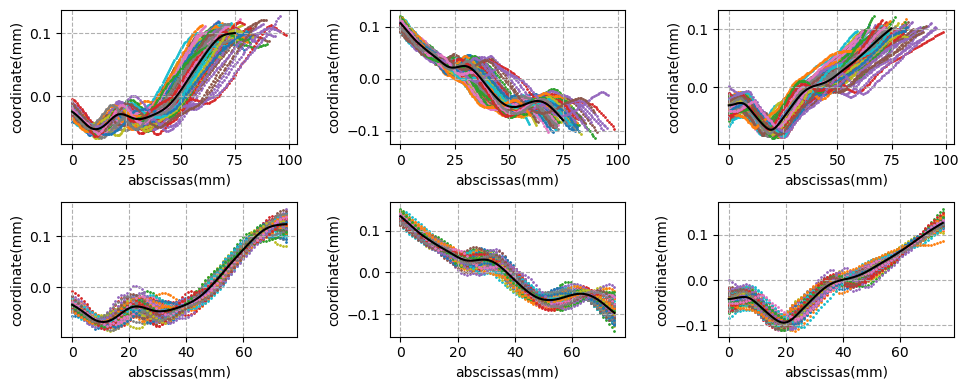

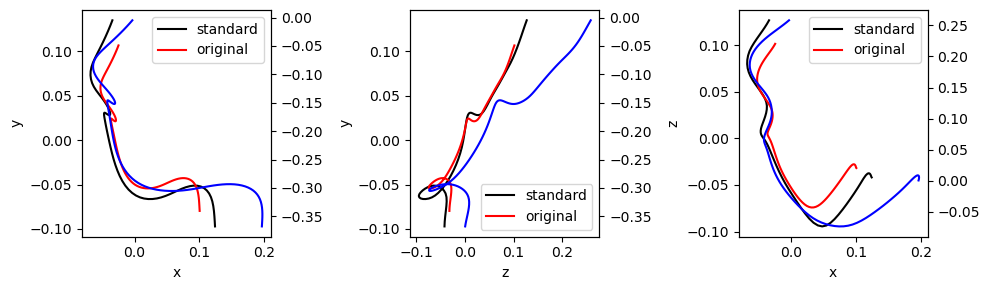

length of resampled_standardized_mean_cl: 0.5213752181774339
length of original_mean_cl: 0.4187309405764255
length of frechet mean shape: 0.7730091775597462
tortuosity of resampled standardized mean curve:
1.5913383049688308
tortuosity of original mean curve:
1.603877003135402
tortuosity of frechet mean curve:
1.5848965786849918


In [183]:
# After aligning the curves, we can visualize the aligned curves in 3D space.

original_centerlines = align_centerlines_procrustes(original_centerlines)
resampled_standardized_centerlines = align_centerlines_procrustes(resampled_standardized_centerlines)

aligned_original_mean_cl = np.mean(original_centerlines, axis=0)
# aligned_original_mean_abscissas = calculate_abscissas(aligned_original_mean_cl)
aligned_original_mean_abscissas = np.mean(abscissas, axis=0)
aligned_resampled_standardized_mean_cl = np.mean(resampled_standardized_centerlines, axis=0)
# aligned_resampled_standardized_mean_abscissas = calculate_abscissas(aligned_resampled_standardized_mean_cl)
aligned_resampled_standardized_mean_abscissas = np.mean(resampled_standardized_abscissas, axis=0)


# 可视化对齐后的曲线
fig = plt.figure(figsize=(10,4), dpi=100)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)


for i in range(len(original_centerlines)):
    ax1.scatter(abscissas[i], original_centerlines[i][:, 0], marker='o', s=1)
    ax2.scatter(abscissas[i], original_centerlines[i][:, 1], marker='o', s=1)
    ax3.scatter(abscissas[i], original_centerlines[i][:, 2], marker='o', s=1)
    ax4.scatter(resampled_standardized_abscissas[i], resampled_standardized_centerlines[i][:, 0], marker='o', s=1)
    ax5.scatter(resampled_standardized_abscissas[i], resampled_standardized_centerlines[i][:, 1], marker='o', s=1)
    ax6.scatter(resampled_standardized_abscissas[i], resampled_standardized_centerlines[i][:, 2], marker='o', s=1)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xlabel("abscissas(mm)")
    ax.set_ylabel("coordinate(mm)")
    ax.grid(linestyle="--")

ax1.plot(aligned_original_mean_abscissas, aligned_original_mean_cl[:, 0], color='k', label='mean')
ax2.plot(aligned_original_mean_abscissas, aligned_original_mean_cl[:, 1], color='k', label='mean')
ax3.plot(aligned_original_mean_abscissas, aligned_original_mean_cl[:, 2], color='k', label='mean')
ax4.plot(aligned_resampled_standardized_mean_abscissas, aligned_resampled_standardized_mean_cl[:, 0], color='k', label='mean')
ax5.plot(aligned_resampled_standardized_mean_abscissas, aligned_resampled_standardized_mean_cl[:, 1], color='k', label='mean')
ax6.plot(aligned_resampled_standardized_mean_abscissas, aligned_resampled_standardized_mean_cl[:, 2], color='k', label='mean')


plt.tight_layout()
plt.show()


adjust_mean_k =1
fig = plt.figure(figsize=(10,3), dpi=100)
ax1 = fig.add_subplot(131)
ax1.plot(aligned_resampled_standardized_mean_cl[:,0],aligned_resampled_standardized_mean_cl[:,1],color='k',label='standard')
ax1.plot(aligned_original_mean_cl[:,0],aligned_original_mean_cl[:,1],color='r',label='original')
ax1_twin = ax1.twinx()
ax1_twin.plot(mean_estimate[:,0]*adjust_mean_k,mean_estimate[:,1]*adjust_mean_k,color='b',label='frechet')
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2 = fig.add_subplot(132)
ax2.plot(aligned_resampled_standardized_mean_cl[:,2][::-1],aligned_resampled_standardized_mean_cl[:,1],color='k',label='standard')
ax2.plot(aligned_original_mean_cl[:,2][::-1],aligned_original_mean_cl[:,1],color='r',label='original')
ax2_twin = ax2.twinx()
ax2_twin.plot(mean_estimate[:,2][::-1]*adjust_mean_k,mean_estimate[:,1]*adjust_mean_k,color='b',label='frechet')
ax2.legend()
ax2.set_xlabel("z")
ax2.set_ylabel("y")
ax3 = fig.add_subplot(133)
ax3.plot(aligned_resampled_standardized_mean_cl[:,0],aligned_resampled_standardized_mean_cl[:,2][::-1],color='k',label='standard')
ax3.plot(aligned_original_mean_cl[:,0],aligned_original_mean_cl[:,2][::-1],color='r',label='original')
ax3_twin = ax3.twinx()
ax3_twin.plot(mean_estimate[:,0]*adjust_mean_k,mean_estimate[:,2][::-1]*adjust_mean_k,color='b',label='frechet')
ax3.legend()
ax3.set_xlabel("x")
ax3.set_ylabel("z")
plt.tight_layout()
plt.show()

print ("length of resampled_standardized_mean_cl:", calculate_curve_length(aligned_resampled_standardized_mean_cl))
print ("length of original_mean_cl:", calculate_curve_length(aligned_original_mean_cl))
print ("length of frechet mean shape:", calculate_curve_length(adjust_mean_k*mean_estimate))
print ("tortuosity of resampled standardized mean curve:")
print(calculate_curve_length(aligned_resampled_standardized_mean_cl)/np.linalg.norm(aligned_resampled_standardized_mean_cl[-1]-aligned_resampled_standardized_mean_cl[0]))
print ("tortuosity of original mean curve:")
print(calculate_curve_length(aligned_original_mean_cl)/np.linalg.norm(aligned_original_mean_cl[-1]-aligned_original_mean_cl[0]))
print ("tortuosity of frechet mean curve:")
print(calculate_curve_length(mean_estimate)/np.linalg.norm(mean_estimate[-1]-mean_estimate[0]))

interpolated_std_centerlines.shape: (88, 750, 3)
interval:, 0.1 explained_variance_ratio_: [0.2735907  0.1751554  0.11484565 0.09296243 0.06886902 0.05329189
 0.04358864 0.04150519 0.02542682 0.02258767]
interpolated_std_centerlines.shape: (88, 250, 3)
interval:, 0.3 explained_variance_ratio_: [0.27317857 0.17528902 0.11450987 0.09273162 0.06915497 0.05354221
 0.04369288 0.04160184 0.02515406 0.02269927]
interpolated_std_centerlines.shape: (88, 75, 3)
interval:, 1.0 explained_variance_ratio_: [0.2714788  0.17580995 0.11348145 0.09202623 0.07008048 0.05448704
 0.04411596 0.04181306 0.02423358 0.02305008]
interpolated_std_centerlines.shape: (88, 25, 3)
interval:, 3.0 explained_variance_ratio_: [0.26634968 0.17680529 0.1115764  0.09058788 0.07166251 0.05709113
 0.04540511 0.04160572 0.02436134 0.02155282]
(4, 88, 10)


C:\Users\cheno\AppData\Local\Temp\ipykernel_17412\228351093.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_17412\228351093.py:88: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


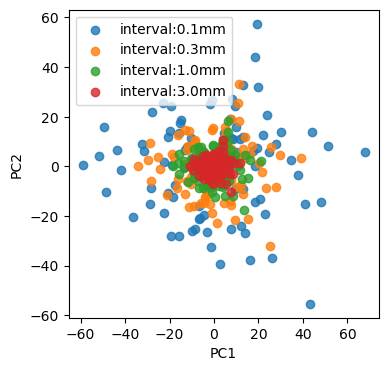

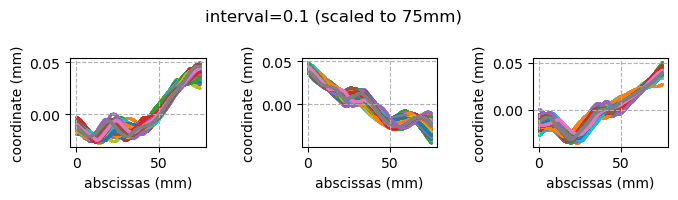

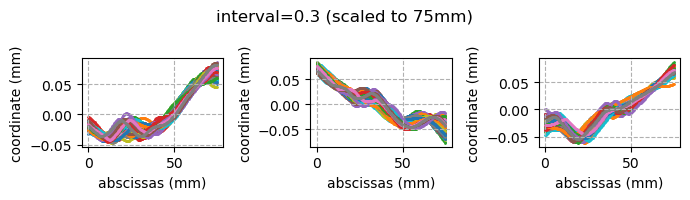

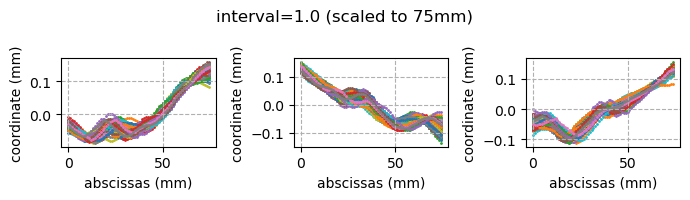

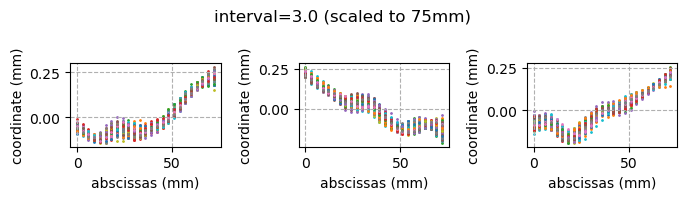

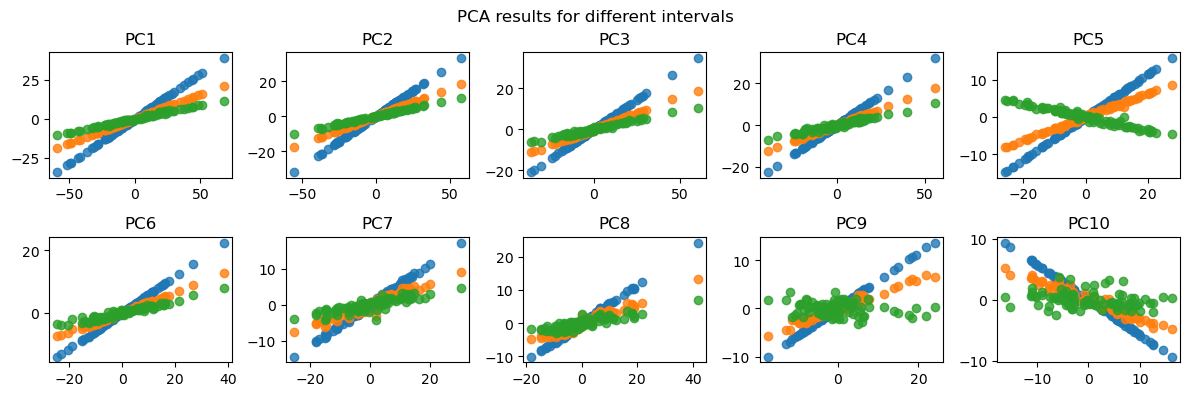

In [184]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

n_components = 10
def resample_centerlines_by_interval(abscissas, original_centerlines, interval):
    num_curves, num_points = abscissas.shape
    
    resampled_centerlines = []
    resampled_abscissas = []

    for i in range(num_curves):
        # 获取当前曲线的abscissas和centerlines
        x = abscissas[i]
        y = original_centerlines[i]

        # 确保 x 是单调递增的
        if not np.all(np.diff(x) > 0):
            raise ValueError(f"abscissas[{i}] 不是严格单调递增的")

        # 生成新的采样点
        new_x = np.arange(x[0], x[-1], interval)
        resampled_abscissas.append(new_x)

        # 对 centerlines 进行插值
        interp_func = interp1d(x, y, axis=0, kind='linear', fill_value='extrapolate')
        new_y = interp_func(new_x)
        resampled_centerlines.append(new_y)

    return np.array(resampled_abscissas, dtype=object), np.array(resampled_centerlines, dtype=object)

fig1 = plt.figure(figsize=(4,4))
ax1 = fig1.add_subplot(111)

std_results = []
interval_var =[0.1,0.3,1.0,3.0]
for interval in interval_var:
    fig2 = plt.figure(figsize=(7,2), dpi=100)
    fig2.suptitle(f"interval={interval} (scaled to 75mm)")
    ax2_1 = fig2.add_subplot(131)
    ax2_2 = fig2.add_subplot(132)
    ax2_3 = fig2.add_subplot(133)
    for  ax in [ax2_1, ax2_2, ax2_3]:
        ax.set_xlabel("abscissas (mm)")
        ax.set_ylabel("coordinate (mm)")
        ax.grid(linestyle="--")
    interpolated_std_abscissas, interpolated_std_centerlines = resample_centerlines_by_interval(resampled_standardized_abscissas, 
                                                                                        resampled_standardized_centerlines, 
                                                                                        interval)

    interpolated_std_centerlines = align_centerlines_procrustes(interpolated_std_centerlines)
    print ("interpolated_std_centerlines.shape:", interpolated_std_centerlines.shape)


    for j in range(len(interpolated_std_centerlines)):
        ax2_1.scatter(interpolated_std_abscissas[j], interpolated_std_centerlines[j, :, 0], marker='o', s=1)
        ax2_2.scatter(interpolated_std_abscissas[j], interpolated_std_centerlines[j, :, 1], marker='o', s=1)
        ax2_3.scatter(interpolated_std_abscissas[j], interpolated_std_centerlines[j, :, 2], marker='o', s=1)
    X = interpolated_std_centerlines.reshape(curve_bs.shape[0], -1)
    fig2.tight_layout(rect=[0, 0, 1, 0.96])
    # 进行标准化 (Z-score)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # 进行 PCA
    pca = PCA(n_components=n_components)
    result = pca.fit_transform(X_scaled)
    std_results.append(result)
    print ("interval:,",interval,"explained_variance_ratio_:", pca.explained_variance_ratio_)

    ax1.scatter(result[:, 0], result[:, 1], alpha=.8, label="interval:"+str(interval)+"mm")
    
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.legend()
fig1.show()

std_results = np.array(std_results)
print (std_results.shape)

fig,axes = plt.subplots(2,5,figsize=(12,4))
axes = axes.flatten()
for i in range(n_components):
    for j in range(1,len(std_results)):
        axes[i].scatter(std_results[0][:, i], std_results[j][:, i], label=f"iv={interval_var[j]}",alpha=.8)
        axes[i].set_title(f"PC{i+1}")
        # axes[i].legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("PCA results for different intervals") 
fig.show()

C:\Users\cheno\AppData\Local\Temp\ipykernel_17412\2221836477.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_17412\2221836477.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_17412\2221836477.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_17412\2221836477.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


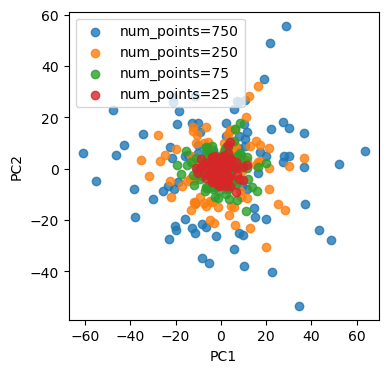

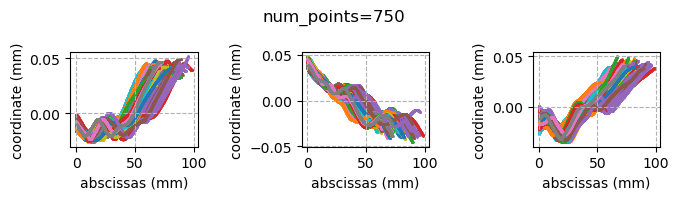

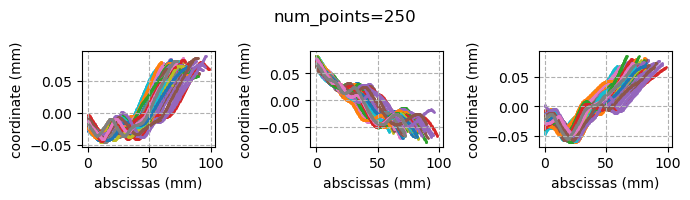

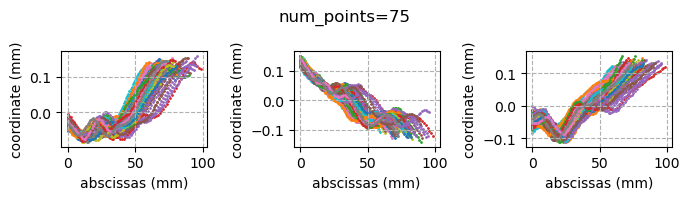

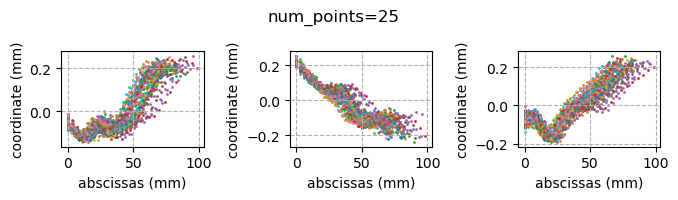

C:\Users\cheno\AppData\Local\Temp\ipykernel_17412\2221836477.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


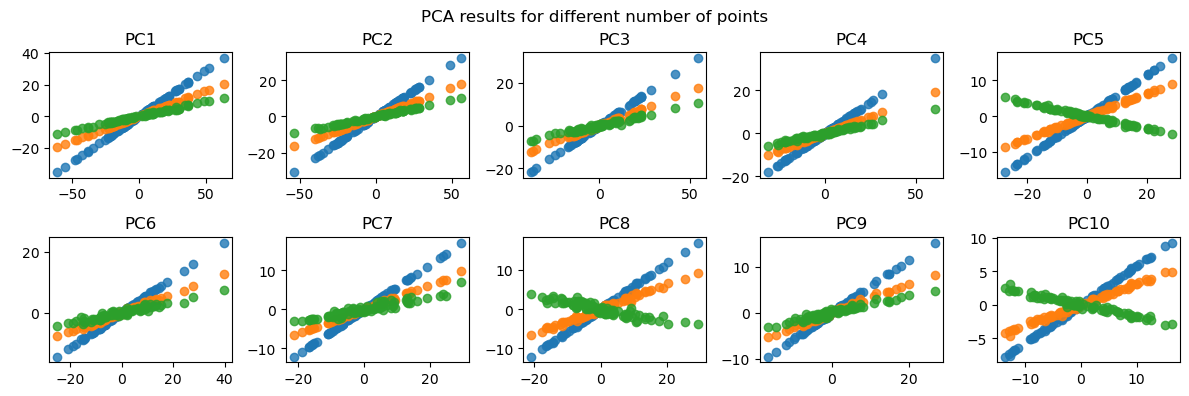

In [185]:
n_components = 10

def resample_centerlines_by_points(abscissas, original_centerlines, num_points):
    num_curves, num_original_points = abscissas.shape

    resampled_centerlines = []
    resampled_abscissas = []

    for i in range(num_curves):
        x = abscissas[i]
        y = original_centerlines[i]

        if not np.all(np.diff(x) > 0):
            raise ValueError(f"abscissas[{i}] 不是严格单调递增的")

        # 生成新的等间距 abscissas（保持原始范围）
        new_x = np.linspace(x[0], x[-1], num_points)

        # 对 centerlines 进行插值
        curve_func = parameterize_curve(y)
        new_y = curve_func(np.linspace(0, 1, num_points))  # 按参数化均匀采样

        resampled_abscissas.append(new_x)
        resampled_centerlines.append(new_y)

    return np.array(resampled_abscissas, dtype=object), np.array(resampled_centerlines, dtype=object)

original_resampling_data = {}
non_std_results = []

fig_pca = plt.figure(figsize=(4, 4), dpi=100)
ax_pca = fig_pca.add_subplot(111)

points_var =[750, 250, 75, 25]
for num_points in points_var:
    new_abscissas, new_centerlines = resample_centerlines_by_points(abscissas, original_centerlines, num_points=num_points)
    original_resampling_data[num_points] = (new_abscissas, new_centerlines)
    new_centerlines = align_centerlines_procrustes(new_centerlines)
    X = new_centerlines.reshape(curve_bs.shape[0], -1)
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_components)
    result = pca.fit_transform(X_scaled)
    ax_pca.scatter(result[:, 0], result[:, 1], label=f"num_points={num_points}",alpha=.8)
    non_std_results.append(result)


    fig = plt.figure(figsize=(7, 2), dpi=100)
    fig.suptitle(f"num_points={num_points}")
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    for i in range(len(original_centerlines)):
        ax1.scatter(new_abscissas[i], new_centerlines[i][:, 0], marker='o', s=1)
        ax2.scatter(new_abscissas[i], new_centerlines[i][:, 1], marker='o', s=1)
        ax3.scatter(new_abscissas[i], new_centerlines[i][:, 2], marker='o', s=1)

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel("abscissas (mm)")
        ax.set_ylabel("coordinate (mm)")
        ax.grid(linestyle="--")

    fig.tight_layout()
    fig.show()
ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")
ax_pca.legend()
plt.show(fig_pca)

fig,axes = plt.subplots(2,5,figsize=(12,4))
axes = axes.flatten()
for i in range(n_components):
    for j in range(1,len(non_std_results)):
        axes[i].scatter(non_std_results[0][:, i], non_std_results[j][:, i], label=f"n_pts={points_var[j]}",alpha=.8)
        axes[i].set_title(f"PC{i+1}")
        # axes[i].legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("PCA results for different number of points")
fig.show()



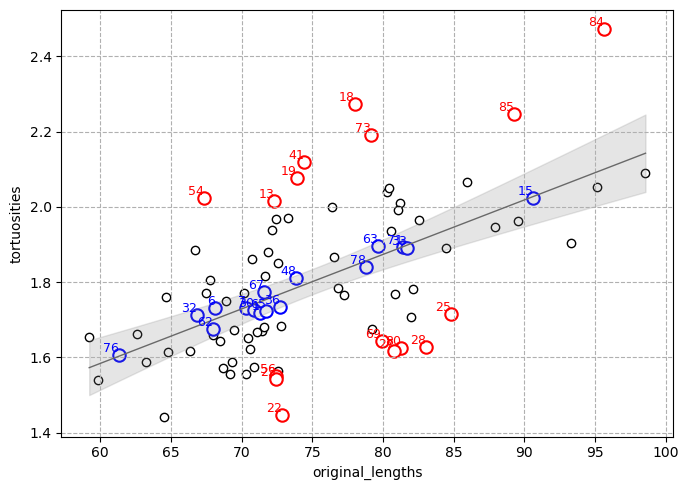

Confidence interval width at x=78.893: 0.075
Indices of points farthest from the line: [56 23 69 25 85 13 80 27 28 19 22 41 73 54 84 18]
Indices of points closest to the line: [71  7 76 15 33 78 30 67 62 48 63  1  6 65 32 36]
71 brava_cut_mirrored\BH0038_ICA_L.vtk
7 brava_cut_mirrored\BG0007_ICA_R.vtk
76 brava_cut_mirrored\BI0001_ICA_L.vtk
15 brava_cut_mirrored\BG0011_ICA_R.vtk
33 brava_cut_mirrored\BH0009_ICA_L.vtk
78 250216tuika\BG0015_L_reverse_MirroredV2.vtk
30 brava_cut_mirrored\BH0005_ICA_R.vtk
67 brava_cut_mirrored\BH0034_ICA_R.vtk
62 brava_cut_mirrored\BH0030_ICA_L.vtk
48 brava_cut_mirrored\BH0018_ICA_R.vtk
63 brava_cut_mirrored\BH0030_ICA_R.vtk
1 brava_cut_mirrored\BG0001_ICA_R.vtk
6 brava_cut_mirrored\BG0007_ICA_L.vtk
65 brava_cut_mirrored\BH0031_ICA_R.vtk
32 brava_cut_mirrored\BH0006_ICA_R.vtk
36 brava_cut_mirrored\BH0010_ICA_R.vtk


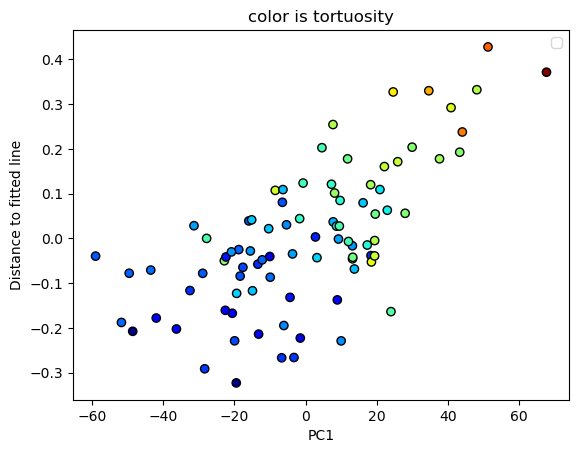

In [187]:
n_highlight = 16  # 需要标出的离散点数量
n_closest = 16  # 需要标出的最近点数量

fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)

# 绘制散点图
sc = ax.scatter(original_lengths, original_tortuosities, color='w', edgecolors='k')
ax.set_ylabel("tortuosities")
ax.set_xlabel("original_lengths")
ax.grid(linestyle="--")

# 线性回归 - statsmodels
X = sm.add_constant(original_lengths)
model = sm.OLS(original_tortuosities, X).fit()

# 获取拟合直线上的 y 值
y_fitted = model.predict(X)

# 计算残差（垂直距离，带符号）
residuals = original_tortuosities - y_fitted

# 找到离直线最远的 n 个点的索引
sorted_indices = np.argsort(np.abs(residuals))[-n_highlight:]

# 标出最远的 n 个点，用红色边框
for idx in sorted_indices:
    ax.scatter(original_lengths[idx], original_tortuosities[idx], facecolor='w', edgecolor='red', s=80, linewidth=1.5)
    ax.text(original_lengths[idx], original_tortuosities[idx], str(idx), fontsize=9, ha='right', va='bottom', color='red')
# 找到离直线最近的 n 个点的索引
closest_indices = np.argsort(np.abs(residuals))[:n_closest]

# 标出最近的 n 个点，用蓝色边框
for idx in closest_indices:
    ax.scatter(original_lengths[idx], original_tortuosities[idx], facecolor='w', edgecolor='blue', s=80, linewidth=1.5)
    ax.text(original_lengths[idx], original_tortuosities[idx], str(idx), fontsize=9, ha='right', va='bottom', color='blue')

# 绘制拟合直线
x_fit = np.linspace(min(original_lengths), max(original_lengths), 100)
X_fit = sm.add_constant(x_fit)
y_fit = model.predict(X_fit)
ax.plot(x_fit, y_fit, color='dimgray', linestyle='-', linewidth=1, label="Fitted Line")

# 获取置信区间 (95%)
pred = model.get_prediction(X_fit)
conf_int = pred.conf_int(alpha=0.05)  # (100, 2)

# 绘制置信区间
ax.fill_between(x_fit, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label="95% Confidence Interval")

plt.tight_layout()
plt.show()

# 计算 x 轴中点处的置信区间宽度
x_mid = np.median(x_fit)
X_mid = np.array([[1, x_mid]])  # 手动组合常数项和 x 值

y_mid_pred = model.predict(X_mid)[0]

# 注意这里也用 X_mid，不要再调用 sm.add_constant()
conf_int_mid = model.get_prediction(X_mid).conf_int(alpha=0.05)[0]
conf_int_width = conf_int_mid[1] - conf_int_mid[0]

print(f"Confidence interval width at x={x_mid:.3f}: {conf_int_width:.3f}")



print("Indices of points farthest from the line:", sorted_indices)
print("Indices of points closest to the line:", closest_indices)
for idx in closest_indices:
    print(idx, files[idx])

def get_distances_to_fit(original_lengths, original_tortuosities):
    # 线性回归 - statsmodels
    X = sm.add_constant(original_lengths)
    model = sm.OLS(original_tortuosities, X).fit()

    # 计算残差（带符号距离）
    y_fitted = model.predict(X)
    residuals = original_tortuosities - y_fitted  # 每个点到拟合直线的垂直距离（正负）

    return residuals

distances = get_distances_to_fit(original_lengths, original_tortuosities)
abs_distances = np.abs(distances)

plt.scatter(std_results[0][:, 0], distances, c=original_tortuosities, cmap='jet', edgecolors='k')
# plt.axhline(y=conf_int_width, color='k', linestyle='--', linewidth=1, label=f"CI Width = {conf_int_width:.3f}")
# plt.axhline(y=2*conf_int_width, color='k', linestyle='--', linewidth=1, label=f"2*CI Width = {2*conf_int_width:.3f}",alpha=0.6)
# plt.axhline(y=3*conf_int_width, color='k', linestyle='--', linewidth=1, label=f"3*CI Width = {3*conf_int_width:.3f}",alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("Distance to fitted line")
plt.title("color is tortuosity")
plt.legend()
plt.show()



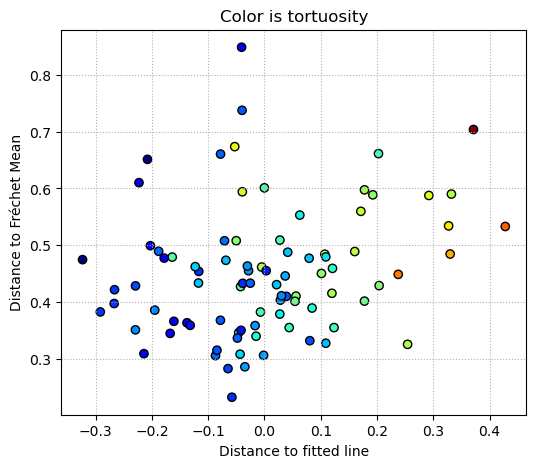

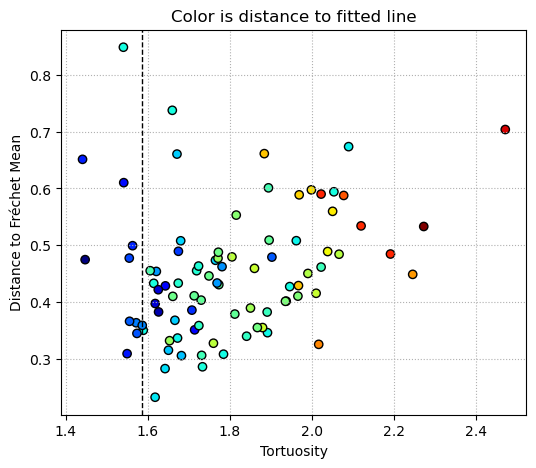

In [188]:
fig = plt.figure(figsize=(6, 5), dpi=100)
ax = fig.add_subplot(111)
ax.scatter(distances, g_dist_to_frechet, c=original_tortuosities, cmap='jet', edgecolors='k')
ax.set_xlabel("Distance to fitted line")
ax.set_ylabel("Distance to Fréchet Mean")
ax.set_title("Color is tortuosity")
ax.grid(linestyle=":")
plt.show()


fig = plt.figure(figsize=(6, 5), dpi=100)
ax = fig.add_subplot(111)
ax.scatter(original_tortuosities, g_dist_to_frechet, c=distances,cmap='jet', edgecolors='k')
ax.axvline(mean_estimate_tortuosity, color='k', linestyle='--', linewidth=1, label="Mean Estimate Tortuosity")
ax.set_xlabel("Tortuosity")
ax.set_ylabel("Distance to Fréchet Mean")
ax.set_title("Color is distance to fitted line")
ax.grid(linestyle=":")
plt.show()

standard PCA explained_variance_ratio_: [0.27411794 0.17178781 0.11623439 0.09226912 0.06862168 0.05348761
 0.04288347 0.04113613 0.02588701 0.02261312 0.0147308  0.01323626
 0.01125277 0.0074598  0.00613443 0.00523422]
PCA transformed shape: (88, 16)


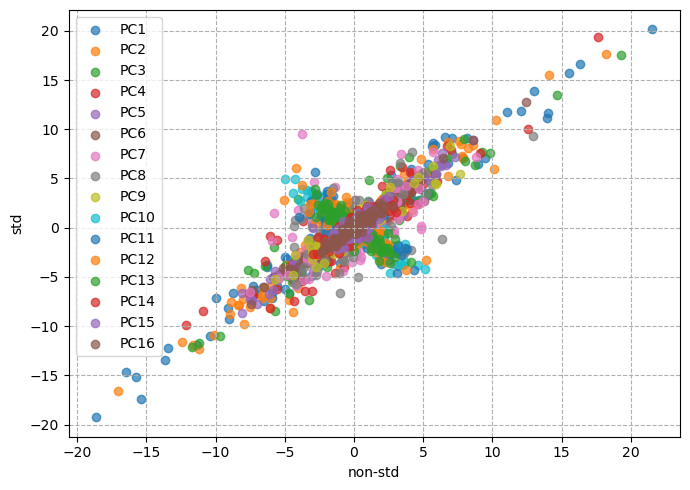


=== PCA 相关性分析 ===
PC1 相关系数: 0.981, p值: 1.157e-62
PC2 相关系数: 0.979, p值: 7.500e-61
PC3 相关系数: 0.937, p值: 5.278e-41
PC4 相关系数: 0.925, p值: 5.237e-38
PC5 相关系数: 0.978, p值: 3.379e-60
PC6 相关系数: 0.978, p值: 9.912e-61
PC7 相关系数: 0.521, p值: 2.003e-07
PC8 相关系数: 0.492, p值: 1.111e-06
PC9 相关系数: 0.920, p值: 7.601e-37
PC10 相关系数: -0.938, p值: 2.457e-41
PC11 相关系数: -0.808, p值: 1.740e-21
PC12 相关系数: -0.814, p值: 5.176e-22
PC13 相关系数: -0.901, p值: 6.889e-33
PC14 相关系数: 0.864, p值: 2.318e-27
PC15 相关系数: 0.809, p值: 1.386e-21
PC16 相关系数: 0.935, p值: 2.007e-40

=== 线性回归分析 ===


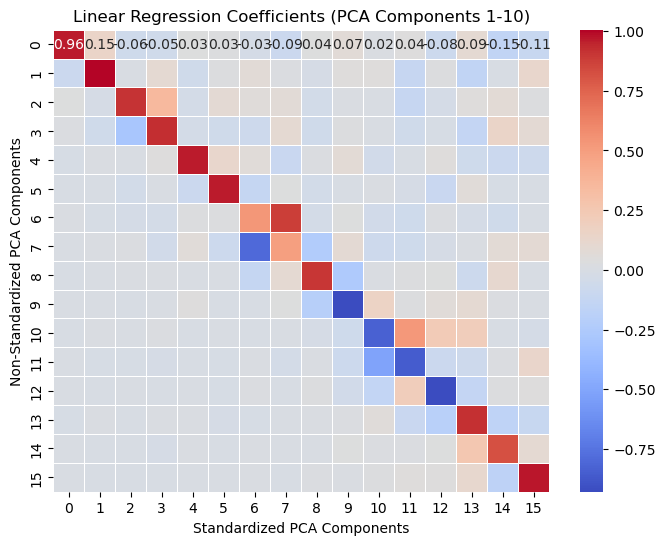


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 14.3837
对角项绝对值和: 13.9142
非对角项绝对值和: 14.3837
非对角项 / 对角项比值: 1.0337


In [189]:
n_components = 16

# 将数据 reshape 为 (79, 3*m)
X = resampled_standardized_centerlines.reshape(curve_bs.shape[0], -1) # 标准化到75mm的centerlines


# 进行标准化 (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 进行 PCA
std_pca = PCA(n_components=n_components)
std_pca_result = std_pca.fit_transform(X_scaled)

print ("standard PCA explained_variance_ratio_:", std_pca.explained_variance_ratio_)
print("PCA transformed shape:", std_pca_result.shape)  # (79, 3)

_, new_centerlines = resample_centerlines_by_points(abscissas, original_centerlines, num_points=75)
new_centerlines = np.array(new_centerlines)
X = new_centerlines.reshape(curve_bs.shape[0], -1)
X_scaled = StandardScaler().fit_transform(X)

non_std_pca = PCA(n_components=n_components)
non_std_pca_result = non_std_pca.fit_transform(X_scaled)


fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
for i in range(n_components):
    ax.scatter(std_pca_result[:, i], non_std_pca_result[:, i], label=f"PC{i+1}", alpha=0.7, marker='o')
ax.set_ylabel("std")
ax.set_xlabel("non-std")
ax.grid(linestyle="--")
ax.legend()
plt.tight_layout()    
plt.show()

W, corr_results, off_diag_ratio = analyze_pca_relationship(std_pca_result, non_std_pca_result, n_components=n_components)



Processing num_points=750, interval=0.1

Processing num_points=250, interval=0.3

Processing num_points=75, interval=1.0

Processing num_points=25, interval=3.0

=== Comparing Non-standardized PCA Results ===

Comparing num_points=750 vs num_points=250

=== PCA 相关性分析 ===
PC1 相关系数: 1.000, p值: 1.297e-192
PC2 相关系数: 1.000, p值: 1.045e-199
PC3 相关系数: 1.000, p值: 7.301e-162
PC4 相关系数: 1.000, p值: 3.499e-165
PC5 相关系数: 1.000, p值: 9.209e-176
PC6 相关系数: 1.000, p值: 1.266e-138
PC7 相关系数: 1.000, p值: 1.528e-162
PC8 相关系数: 1.000, p值: 4.262e-138
PC9 相关系数: 1.000, p值: 9.724e-133
PC10 相关系数: 1.000, p值: 4.646e-135
PC11 相关系数: 0.998, p值: 2.369e-107
PC12 相关系数: 0.998, p值: 4.918e-104
PC13 相关系数: 1.000, p值: 5.692e-134
PC14 相关系数: 1.000, p值: 1.254e-137
PC15 相关系数: 1.000, p值: 1.506e-139
PC16 相关系数: 1.000, p值: 3.146e-138

=== 线性回归分析 ===


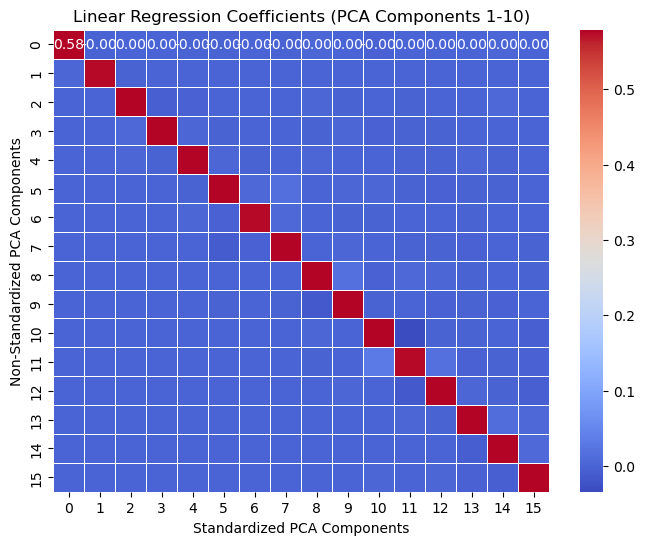


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 0.4746
对角项绝对值和: 9.2384
非对角项绝对值和: 0.4746
非对角项 / 对角项比值: 0.0514

Comparing num_points=750 vs num_points=75

=== PCA 相关性分析 ===
PC1 相关系数: 1.000, p值: 8.811e-137
PC2 相关系数: 1.000, p值: 4.054e-144
PC3 相关系数: 0.998, p值: 7.526e-108
PC4 相关系数: 0.999, p值: 1.783e-111
PC5 相关系数: 0.999, p值: 1.360e-121
PC6 相关系数: 0.994, p值: 1.264e-84
PC7 相关系数: 0.998, p值: 1.735e-104
PC8 相关系数: 0.994, p值: 3.496e-83
PC9 相关系数: 0.994, p值: 8.548e-84
PC10 相关系数: 0.995, p值: 1.581e-87
PC11 相关系数: 0.973, p值: 8.422e-57
PC12 相关系数: 0.967, p值: 7.563e-53
PC13 相关系数: 0.992, p值: 2.404e-79
PC14 相关系数: 0.993, p值: 3.416e-81
PC15 相关系数: 0.993, p值: 4.858e-82
PC16 相关系数: -0.992, p值: 3.583e-80

=== 线性回归分析 ===


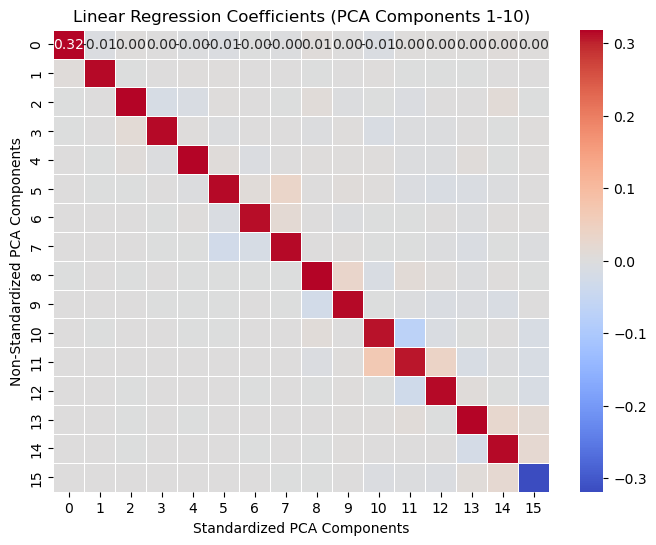


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 1.1233
对角项绝对值和: 5.0342
非对角项绝对值和: 1.1233
非对角项 / 对角项比值: 0.2231

Comparing num_points=750 vs num_points=25

=== PCA 相关性分析 ===
PC1 相关系数: 0.996, p值: 9.731e-94
PC2 相关系数: 0.998, p值: 2.065e-101
PC3 相关系数: 0.987, p值: 1.585e-69
PC4 相关系数: 0.989, p值: 8.327e-74
PC5 相关系数: -0.994, p值: 1.052e-84
PC6 相关系数: 0.957, p值: 5.079e-48
PC7 相关系数: 0.945, p值: 1.820e-43
PC8 相关系数: -0.917, p值: 3.616e-36
PC9 相关系数: 0.966, p值: 4.941e-52
PC10 相关系数: -0.978, p值: 3.498e-60
PC11 相关系数: 0.875, p值: 8.466e-29
PC12 相关系数: 0.816, p值: 3.844e-22
PC13 相关系数: -0.932, p值: 1.473e-39
PC14 相关系数: 0.922, p值: 4.265e-37
PC15 相关系数: 0.774, p值: 8.736e-19
PC16 相关系数: -0.761, p值: 7.843e-18

=== 线性回归分析 ===


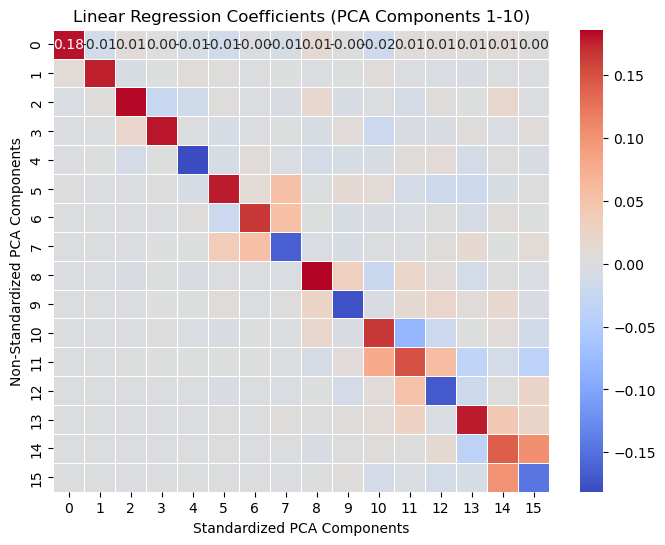


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 2.0557
对角项绝对值和: 2.7274
非对角项绝对值和: 2.0557
非对角项 / 对角项比值: 0.7537

Comparing num_points=250 vs num_points=75

=== PCA 相关性分析 ===
PC1 相关系数: 1.000, p值: 2.944e-146
PC2 相关系数: 1.000, p值: 1.149e-153
PC3 相关系数: 0.999, p值: 7.480e-118
PC4 相关系数: 0.999, p值: 1.426e-121
PC5 相关系数: 1.000, p值: 1.560e-131
PC6 相关系数: 0.997, p值: 1.348e-94
PC7 相关系数: 0.999, p值: 2.572e-113
PC8 相关系数: 0.996, p值: 7.788e-93
PC9 相关系数: 0.997, p值: 2.543e-95
PC10 相关系数: 0.997, p值: 1.263e-99
PC11 相关系数: 0.985, p值: 1.185e-67
PC12 相关系数: 0.981, p值: 1.900e-63
PC13 相关系数: 0.995, p值: 4.380e-89
PC14 相关系数: 0.996, p值: 2.104e-90
PC15 相关系数: 0.996, p值: 6.070e-91
PC16 相关系数: -0.995, p值: 7.361e-89

=== 线性回归分析 ===


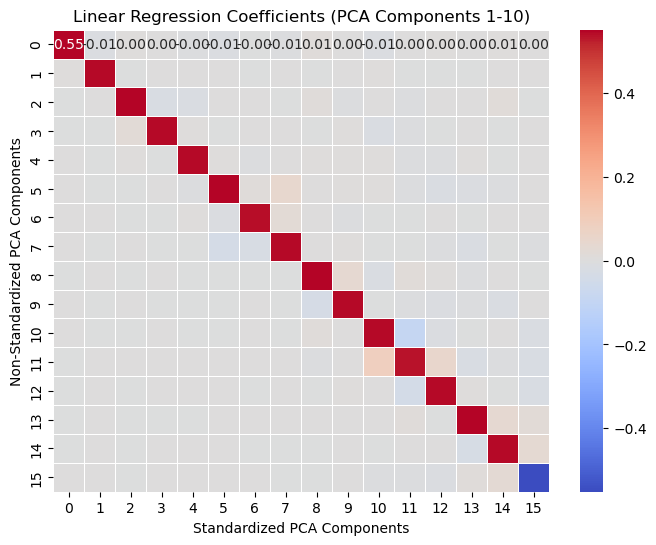


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 1.4955
对角项绝对值和: 8.7426
非对角项绝对值和: 1.4955
非对角项 / 对角项比值: 0.1711

Comparing num_points=250 vs num_points=25

=== PCA 相关性分析 ===
PC1 相关系数: 0.997, p值: 1.881e-96
PC2 相关系数: 0.998, p值: 3.716e-104
PC3 相关系数: 0.989, p值: 9.875e-73
PC4 相关系数: 0.991, p值: 4.719e-77
PC5 相关系数: -0.995, p值: 6.911e-88
PC6 相关系数: 0.964, p值: 2.759e-51
PC7 相关系数: 0.949, p值: 6.949e-45
PC8 相关系数: -0.926, p值: 3.739e-38
PC9 相关系数: 0.972, p值: 7.608e-56
PC10 相关系数: -0.983, p值: 1.338e-64
PC11 相关系数: 0.900, p值: 8.160e-33
PC12 相关系数: 0.849, p值: 1.327e-25
PC13 相关系数: -0.941, p值: 2.421e-42
PC14 相关系数: 0.931, p值: 2.193e-39
PC15 相关系数: 0.787, p值: 1.023e-19
PC16 相关系数: -0.773, p值: 1.153e-18

=== 线性回归分析 ===


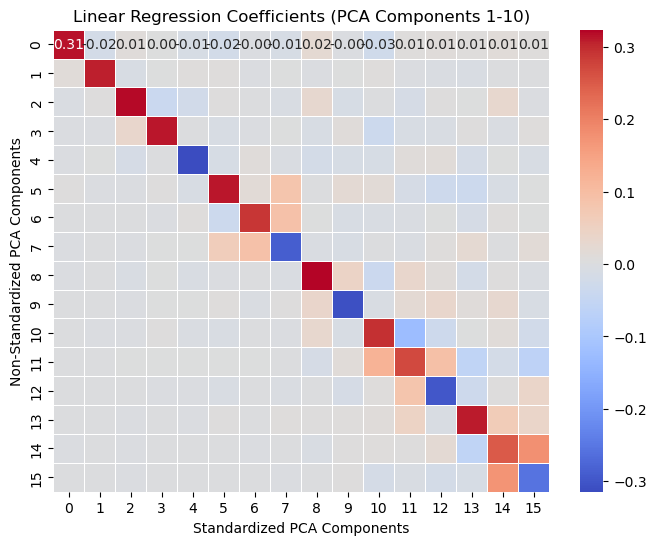


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 3.3201
对角项绝对值和: 4.7663
非对角项绝对值和: 3.3201
非对角项 / 对角项比值: 0.6966

Comparing num_points=75 vs num_points=25

=== PCA 相关性分析 ===
PC1 相关系数: 0.998, p值: 8.932e-108
PC2 相关系数: 0.999, p值: 1.641e-115
PC3 相关系数: 0.994, p值: 1.084e-85
PC4 相关系数: 0.996, p值: 5.191e-90
PC5 相关系数: -0.998, p值: 8.970e-101
PC6 相关系数: 0.983, p值: 1.066e-64
PC7 相关系数: 0.963, p值: 7.260e-51
PC8 相关系数: -0.952, p值: 4.595e-46
PC9 相关系数: 0.987, p值: 1.810e-69
PC10 相关系数: -0.992, p值: 2.359e-79
PC11 相关系数: 0.959, p值: 8.317e-49
PC12 相关系数: 0.932, p值: 1.476e-39
PC13 相关系数: -0.969, p值: 7.316e-54
PC14 相关系数: 0.960, p值: 2.955e-49
PC15 相关系数: 0.832, p值: 1.051e-23
PC16 相关系数: 0.819, p值: 2.045e-22

=== 线性回归分析 ===


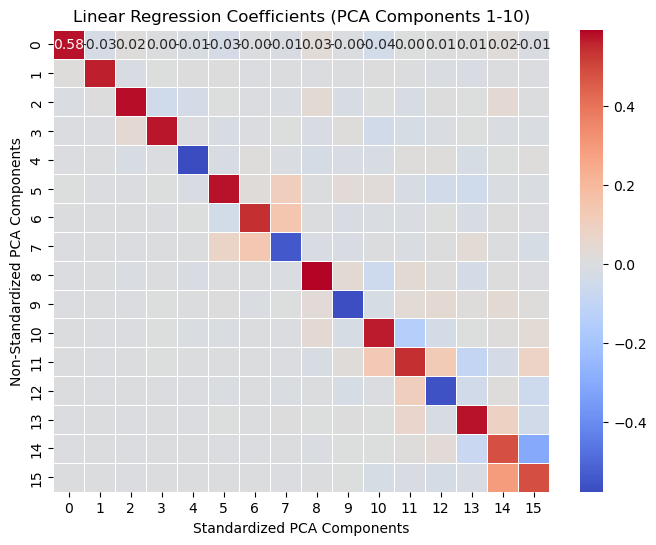


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 4.5759
对角项绝对值和: 8.9113
非对角项绝对值和: 4.5759
非对角项 / 对角项比值: 0.5135

=== Comparing Standardized PCA Results ===

Comparing interval=0.1 vs interval=0.3

=== PCA 相关性分析 ===
PC1 相关系数: 1.000, p值: 4.052e-189
PC2 相关系数: 1.000, p值: 2.045e-206
PC3 相关系数: 1.000, p值: 9.698e-169
PC4 相关系数: 1.000, p值: 3.856e-161
PC5 相关系数: 1.000, p值: 2.080e-163
PC6 相关系数: 1.000, p值: 9.279e-145
PC7 相关系数: 0.998, p值: 6.741e-106
PC8 相关系数: 0.998, p值: 3.046e-105
PC9 相关系数: 1.000, p值: 5.795e-137
PC10 相关系数: -1.000, p值: 6.208e-137
PC11 相关系数: 1.000, p值: 9.722e-135
PC12 相关系数: 1.000, p值: 3.699e-140
PC13 相关系数: 1.000, p值: 1.352e-141
PC14 相关系数: -0.999, p值: 8.738e-126
PC15 相关系数: 1.000, p值: 7.944e-142
PC16 相关系数: 0.999, p值: 4.080e-123

=== 线性回归分析 ===


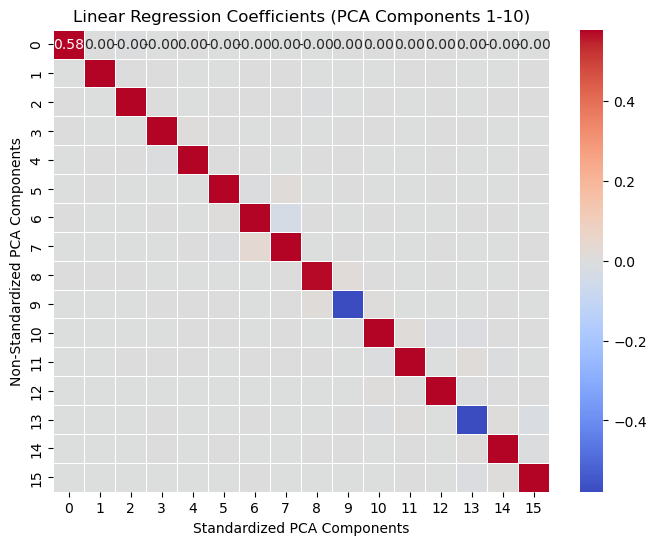


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 0.5321
对角项绝对值和: 9.2375
非对角项绝对值和: 0.5321
非对角项 / 对角项比值: 0.0576

Comparing interval=0.1 vs interval=1.0

=== PCA 相关性分析 ===
PC1 相关系数: 1.000, p值: 6.678e-133
PC2 相关系数: 1.000, p值: 1.019e-150
PC3 相关系数: 0.999, p值: 6.522e-112
PC4 相关系数: 0.998, p值: 2.071e-102
PC5 相关系数: 0.998, p值: 8.319e-106
PC6 相关系数: 0.995, p值: 1.261e-89
PC7 相关系数: 0.967, p值: 6.761e-53
PC8 相关系数: 0.966, p值: 1.619e-52
PC9 相关系数: 0.974, p值: 1.692e-57
PC10 相关系数: -0.974, p值: 1.936e-57
PC11 相关系数: 0.992, p值: 1.263e-78
PC12 相关系数: 0.993, p值: 1.562e-82
PC13 相关系数: 0.994, p值: 6.038e-85
PC14 相关系数: -0.986, p值: 1.132e-68
PC15 相关系数: 0.995, p值: 8.532e-87
PC16 相关系数: 0.984, p值: 1.244e-66

=== 线性回归分析 ===


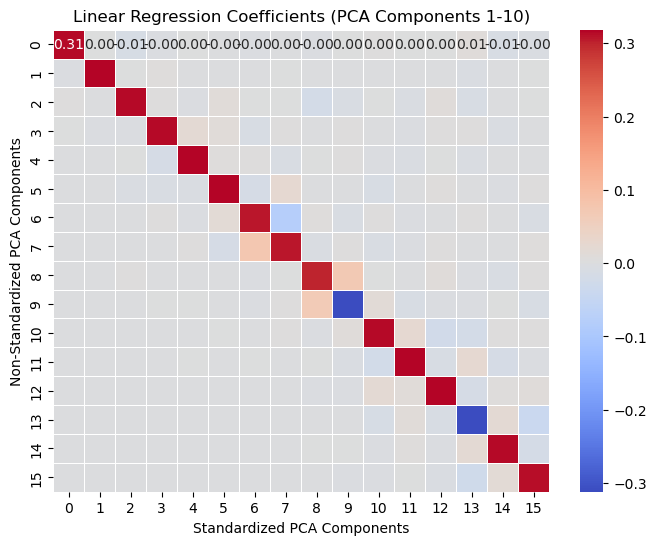


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 1.3694
对角项绝对值和: 5.0123
非对角项绝对值和: 1.3694
非对角项 / 对角项比值: 0.2732

Comparing interval=0.1 vs interval=3.0

=== PCA 相关性分析 ===
PC1 相关系数: 0.995, p值: 4.046e-89
PC2 相关系数: 0.998, p值: 4.273e-107
PC3 相关系数: 0.986, p值: 9.341e-69
PC4 相关系数: 0.969, p值: 9.699e-54
PC5 相关系数: -0.976, p值: 6.600e-59
PC6 相关系数: 0.964, p值: 3.107e-51
PC7 相关系数: 0.854, p值: 4.204e-26
PC8 相关系数: 0.857, p值: 1.708e-26
PC9 相关系数: -0.221, p值: 3.885e-02
PC10 相关系数: -0.221, p值: 3.858e-02
PC11 相关系数: -0.941, p值: 2.329e-42
PC12 相关系数: 0.938, p值: 2.407e-41
PC13 相关系数: 0.941, p值: 4.077e-42
PC14 相关系数: 0.856, p值: 2.003e-26
PC15 相关系数: 0.960, p值: 1.785e-49
PC16 相关系数: 0.826, p值: 3.577e-23

=== 线性回归分析 ===


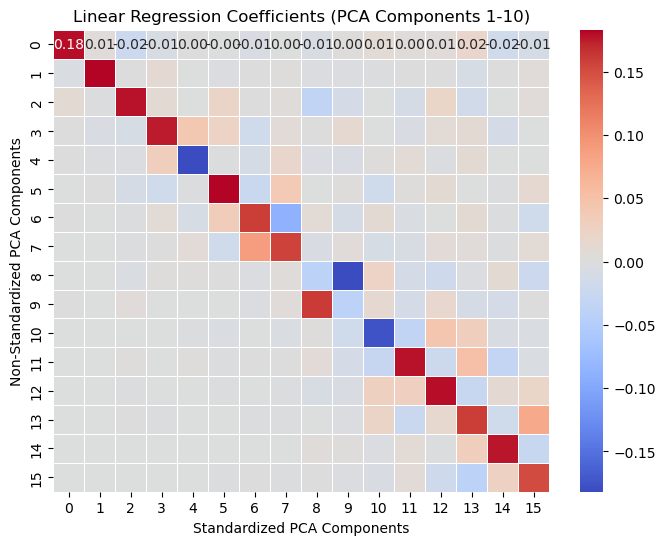


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 2.4030
对角项绝对值和: 2.4927
非对角项绝对值和: 2.4030
非对角项 / 对角项比值: 0.9640

Comparing interval=0.3 vs interval=1.0

=== PCA 相关性分析 ===
PC1 相关系数: 1.000, p值: 2.866e-142
PC2 相关系数: 1.000, p值: 3.166e-160
PC3 相关系数: 0.999, p值: 4.422e-121
PC4 相关系数: 0.999, p值: 4.545e-111
PC5 相关系数: 0.999, p值: 1.017e-114
PC6 相关系数: 0.997, p值: 3.037e-99
PC7 相关系数: 0.981, p值: 6.304e-63
PC8 相关系数: 0.981, p值: 1.200e-62
PC9 相关系数: 0.980, p值: 6.079e-62
PC10 相关系数: 0.980, p值: 6.831e-62
PC11 相关系数: 0.995, p值: 6.189e-88
PC12 相关系数: 0.996, p值: 1.915e-91
PC13 相关系数: 0.996, p值: 4.647e-94
PC14 相关系数: 0.991, p值: 1.148e-77
PC15 相关系数: 0.997, p值: 2.600e-96
PC16 相关系数: 0.990, p值: 9.072e-76

=== 线性回归分析 ===


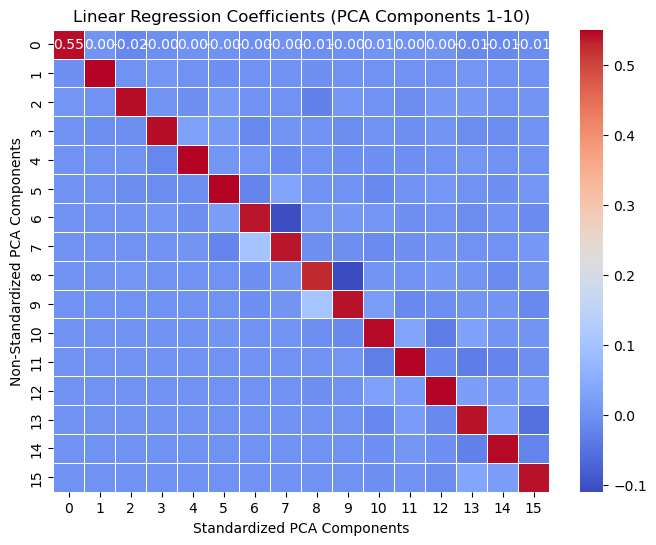


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 1.8717
对角项绝对值和: 8.7128
非对角项绝对值和: 1.8717
非对角项 / 对角项比值: 0.2148

Comparing interval=0.3 vs interval=3.0

=== PCA 相关性分析 ===
PC1 相关系数: 0.996, p值: 9.257e-92
PC2 相关系数: 0.998, p值: 8.843e-110
PC3 相关系数: 0.988, p值: 2.571e-71
PC4 相关系数: 0.972, p值: 8.051e-56
PC5 相关系数: -0.979, p值: 5.018e-61
PC6 相关系数: 0.969, p值: 3.600e-54
PC7 相关系数: 0.883, p值: 4.902e-30
PC8 相关系数: 0.887, p值: 1.119e-30
PC9 相关系数: -0.244, p值: 2.221e-02
PC10 相关系数: 0.244, p值: 2.195e-02
PC11 相关系数: -0.950, p值: 2.082e-45
PC12 相关系数: 0.946, p值: 8.477e-44
PC13 相关系数: 0.948, p值: 1.573e-44
PC14 相关系数: -0.874, p值: 1.195e-28
PC15 相关系数: 0.966, p值: 1.874e-52
PC16 相关系数: 0.846, p值: 2.956e-25

=== 线性回归分析 ===


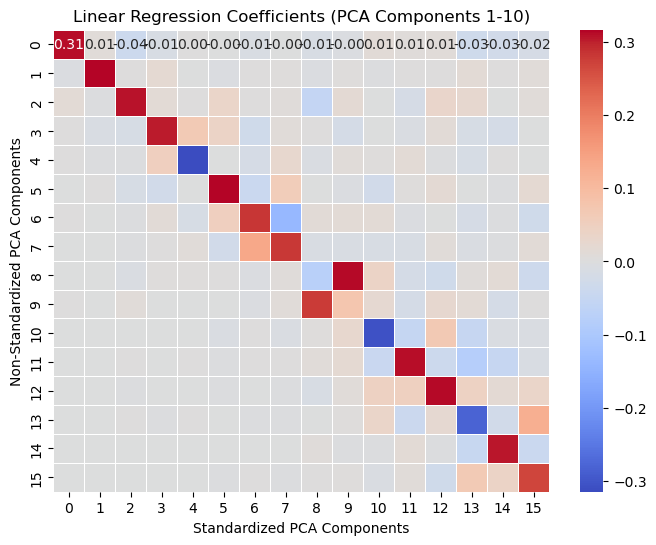


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 3.9077
对角项绝对值和: 4.3740
非对角项绝对值和: 3.9077
非对角项 / 对角项比值: 0.8934

Comparing interval=1.0 vs interval=3.0

=== PCA 相关性分析 ===
PC1 相关系数: 0.998, p值: 7.698e-103
PC2 相关系数: 0.999, p值: 7.577e-121
PC3 相关系数: 0.993, p值: 2.214e-82
PC4 相关系数: 0.983, p值: 3.589e-65
PC5 相关系数: -0.987, p值: 2.187e-70
PC6 相关系数: 0.984, p值: 1.721e-66
PC7 相关系数: 0.956, p值: 1.360e-47
PC8 相关系数: 0.960, p值: 1.822e-49
PC9 相关系数: -0.428, p值: 3.248e-05
PC10 相关系数: 0.429, p值: 3.113e-05
PC11 相关系数: -0.976, p值: 7.172e-59
PC12 相关系数: 0.970, p值: 1.137e-54
PC13 相关系数: 0.971, p值: 3.715e-55
PC14 相关系数: -0.927, p值: 1.722e-38
PC15 相关系数: 0.983, p值: 3.577e-65
PC16 相关系数: 0.908, p值: 2.587e-34

=== 线性回归分析 ===


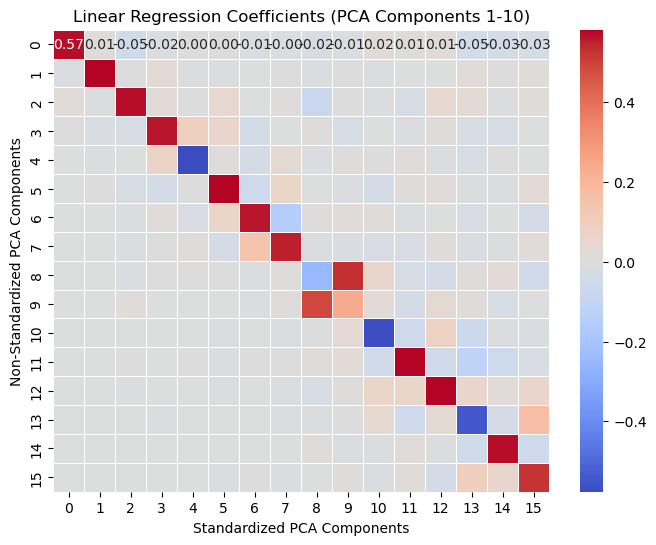


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 5.4388
对角项绝对值和: 8.4054
非对角项绝对值和: 5.4388
非对角项 / 对角项比值: 0.6471

=== Comparing Non-standardized vs Standardized PCA Results ===

Comparing num_points=750 vs interval=0.1

=== PCA 相关性分析 ===
PC1 相关系数: 0.981, p值: 5.432e-63
PC2 相关系数: 0.978, p值: 1.665e-60
PC3 相关系数: 0.928, p值: 1.530e-38
PC4 相关系数: 0.917, p值: 4.920e-36
PC5 相关系数: 0.977, p值: 2.134e-59
PC6 相关系数: 0.971, p值: 2.754e-55
PC7 相关系数: 0.757, p值: 1.430e-17
PC8 相关系数: 0.727, p值: 1.042e-15
PC9 相关系数: 0.915, p值: 1.423e-35
PC10 相关系数: 0.936, p值: 7.247e-41
PC11 相关系数: 0.838, p值: 2.481e-24
PC12 相关系数: 0.833, p值: 8.000e-24
PC13 相关系数: -0.881, p值: 9.442e-30
PC14 相关系数: -0.858, p值: 1.238e-26
PC15 相关系数: 0.826, p值: 3.713e-23
PC16 相关系数: 0.934, p值: 2.445e-40

=== 线性回归分析 ===


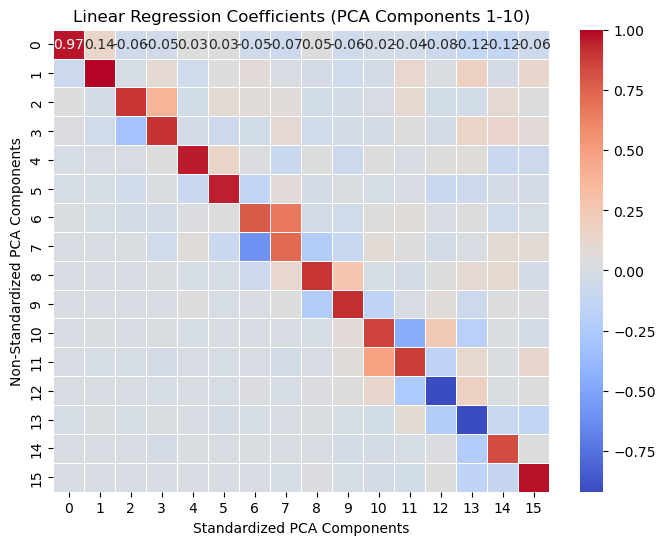


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 13.9808
对角项绝对值和: 14.4115
非对角项绝对值和: 13.9808
非对角项 / 对角项比值: 0.9701

Comparing num_points=250 vs interval=0.3

=== PCA 相关性分析 ===
PC1 相关系数: 0.982, p值: 4.136e-64
PC2 相关系数: 0.979, p值: 2.056e-61
PC3 相关系数: 0.933, p值: 7.014e-40
PC4 相关系数: 0.921, p值: 5.411e-37
PC5 相关系数: 0.977, p值: 2.420e-59
PC6 相关系数: 0.972, p值: 9.597e-56
PC7 相关系数: 0.713, p值: 6.843e-15
PC8 相关系数: 0.684, p值: 2.148e-13
PC9 相关系数: 0.915, p值: 1.238e-35
PC10 相关系数: -0.936, p值: 1.023e-40
PC11 相关系数: 0.799, p值: 1.084e-20
PC12 相关系数: 0.792, p值: 4.205e-20
PC13 相关系数: -0.879, p值: 1.894e-29
PC14 相关系数: 0.869, p值: 5.004e-28
PC15 相关系数: 0.821, p值: 1.284e-22
PC16 相关系数: 0.938, p值: 2.685e-41

=== 线性回归分析 ===


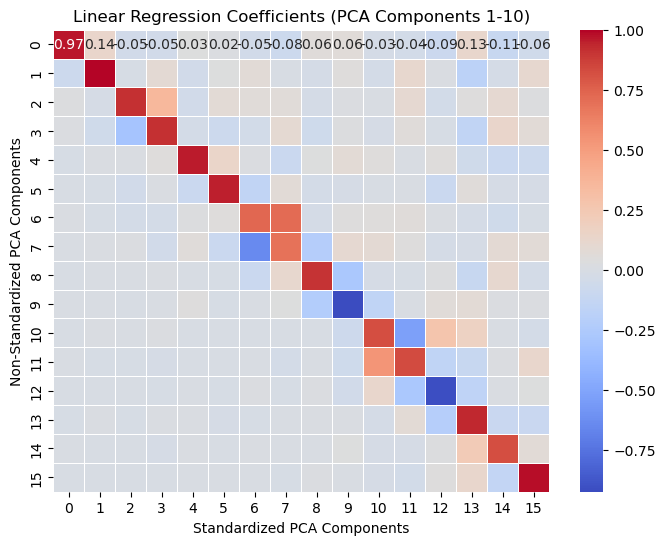


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 14.0749
对角项绝对值和: 14.2598
非对角项绝对值和: 14.0749
非对角项 / 对角项比值: 0.9870

Comparing num_points=75 vs interval=1.0

=== PCA 相关性分析 ===
PC1 相关系数: 0.985, p值: 2.373e-67
PC2 相关系数: 0.982, p值: 2.398e-64
PC3 相关系数: 0.948, p值: 2.142e-44
PC4 相关系数: 0.933, p值: 6.114e-40
PC5 相关系数: 0.974, p值: 1.980e-57
PC6 相关系数: 0.973, p值: 2.316e-56
PC7 相关系数: 0.544, p值: 4.193e-08
PC8 相关系数: 0.518, p值: 2.368e-07
PC9 相关系数: 0.939, p值: 1.001e-41
PC10 相关系数: -0.959, p值: 4.490e-49
PC11 相关系数: 0.646, p值: 1.058e-11
PC12 相关系数: 0.635, p值: 3.119e-11
PC13 相关系数: -0.876, p值: 5.732e-29
PC14 相关系数: 0.893, p值: 1.741e-31
PC15 相关系数: 0.792, p值: 4.336e-20
PC16 相关系数: -0.923, p值: 1.663e-37

=== 线性回归分析 ===


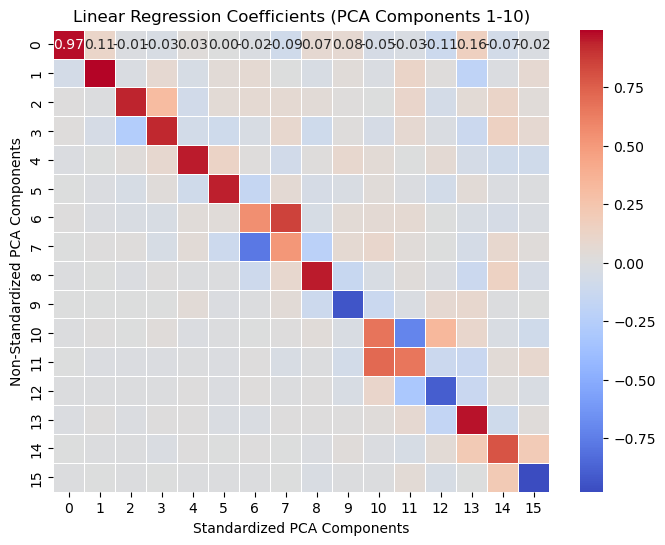


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 14.5085
对角项绝对值和: 13.6673
非对角项绝对值和: 14.5085
非对角项 / 对角项比值: 1.0615

Comparing num_points=25 vs interval=3.0

=== PCA 相关性分析 ===
PC1 相关系数: 0.985, p值: 4.708e-67
PC2 相关系数: 0.986, p值: 2.571e-69
PC3 相关系数: 0.961, p值: 6.777e-50
PC4 相关系数: 0.927, p值: 2.129e-38
PC5 相关系数: 0.940, p值: 7.707e-42
PC6 相关系数: 0.958, p值: 1.211e-48
PC7 相关系数: 0.073, p值: 5.010e-01
PC8 相关系数: -0.046, p值: 6.734e-01
PC9 相关系数: -0.567, p值: 8.611e-09
PC10 相关系数: 0.539, p值: 5.926e-08
PC11 相关系数: -0.318, p值: 2.555e-03
PC12 相关系数: 0.321, p值: 2.304e-03
PC13 相关系数: 0.889, p值: 7.421e-31
PC14 相关系数: -0.829, p值: 2.183e-23
PC15 相关系数: 0.457, p值: 7.676e-06
PC16 相关系数: -0.485, p值: 1.683e-06

=== 线性回归分析 ===


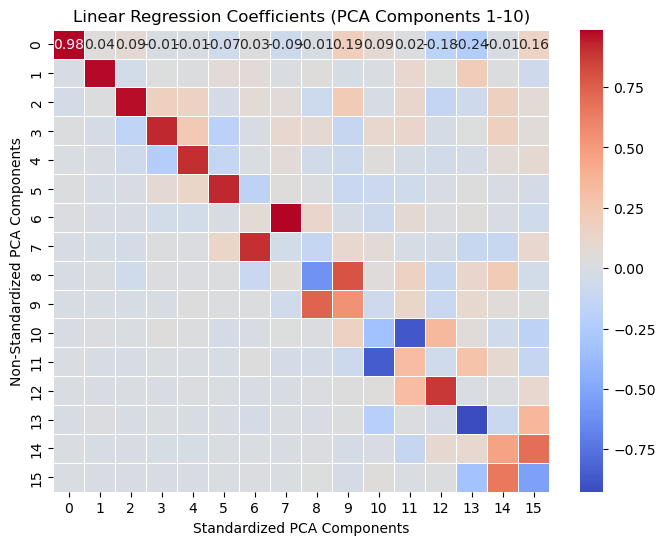


=== 变换矩阵统计信息 ===
变换矩阵非对角项绝对值总和: 20.4094
对角项绝对值和: 10.4055
非对角项绝对值和: 20.4094
非对角项 / 对角项比值: 1.9614


In [190]:
from itertools import combinations

points_var = [750, 250, 75, 25]
interval_var = [0.1, 0.3, 1.0, 3.0]

original_resampling_data = {}
non_std_pca_results = {}
std_pca_results = {}

# 遍历不同采样设置，计算PCA结果
for num_points, interval in zip(points_var, interval_var):
    print(f"\nProcessing num_points={num_points}, interval={interval}")

    # 非标准化采样
    new_abscissas, new_centerlines = resample_centerlines_by_points(abscissas, original_centerlines, num_points=num_points)
    original_resampling_data[num_points] = (new_abscissas, new_centerlines)

    new_centerlines = align_centerlines_procrustes(new_centerlines)
    non_std_X = new_centerlines.reshape(curve_bs.shape[0], -1)
    non_std_X_scaled = StandardScaler().fit_transform(non_std_X)
    non_std_pca = PCA(n_components=n_components)
    non_std_result = non_std_pca.fit_transform(non_std_X_scaled)

    non_std_pca_results[num_points] = non_std_result

    # 标准化采样
    interpolated_std_abscissas, interpolated_std_centerlines = resample_centerlines_by_interval(
        resampled_standardized_abscissas, resampled_standardized_centerlines, interval
    )

    interpolated_std_centerlines = align_centerlines_procrustes(interpolated_std_centerlines)
    std_X = interpolated_std_centerlines.reshape(curve_bs.shape[0], -1)
    std_X_scaled = StandardScaler().fit_transform(std_X)
    std_pca = PCA(n_components=n_components)
    std_result = std_pca.fit_transform(std_X_scaled)

    std_pca_results[interval] = std_result

# 比较 非标准化PCA 内部关系
print("\n=== Comparing Non-standardized PCA Results ===")
for (p1, p2) in combinations(points_var, 2):
    print(f"\nComparing num_points={p1} vs num_points={p2}")
    analyze_pca_relationship(
        non_std_pca_results[p1], non_std_pca_results[p2], n_components=n_components
    )

# 比较 标准化PCA 内部关系
print("\n=== Comparing Standardized PCA Results ===")
for (i1, i2) in combinations(interval_var, 2):
    print(f"\nComparing interval={i1} vs interval={i2}")
    analyze_pca_relationship(
        std_pca_results[i1], std_pca_results[i2], n_components=n_components
    )

# 比较 非标准化PCA vs 标准化PCA 的关系 (你原本已有的部分)
print("\n=== Comparing Non-standardized vs Standardized PCA Results ===")
for num_points, interval in zip(points_var, interval_var):
    print(f"\nComparing num_points={num_points} vs interval={interval}")
    analyze_pca_relationship(
        std_pca_results[interval], non_std_pca_results[num_points], n_components=n_components
    )


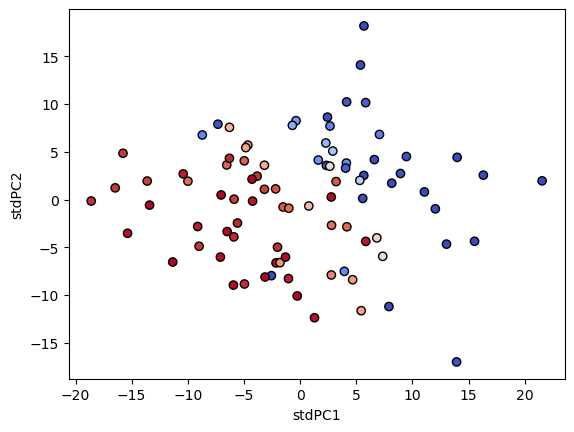

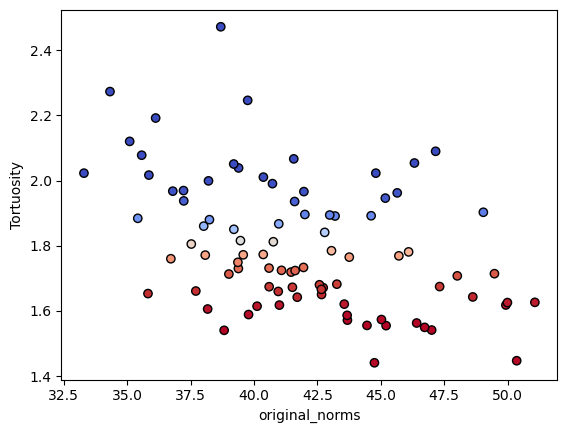

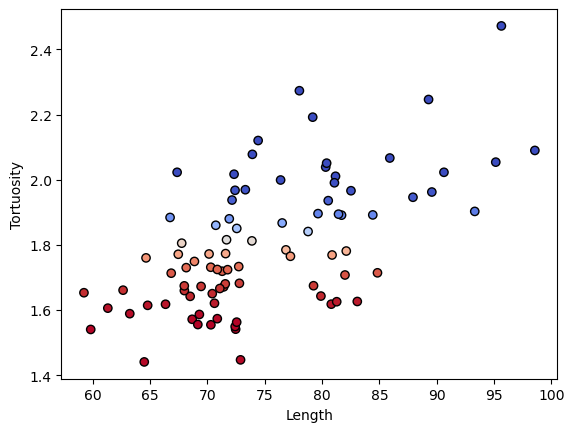

original_norms vs Tortuosity 相关系数: -0.436, p值: 2.153e-05
Length vs Tortuosity 相关系数: 0.602, p值: 5.369e-10
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4007.
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           7.79e-85
Time:                        19:27:12   Log-Likelihood:                 218.65
No. Observations:                  88   AIC:                            -431.3
Df Residuals:                      85   BIC:                            -423.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [191]:


plt.scatter(std_pca_result[:, 0], std_pca_result[:,1], c=tortuosity_probs[:,1], cmap='coolwarm', edgecolors='k')
plt.xlabel("stdPC1")
plt.ylabel("stdPC2")
plt.show()

plt.scatter(original_norms, original_tortuosities, c=tortuosity_probs[:,1], cmap='coolwarm', edgecolors='k')
plt.xlabel("original_norms")
plt.ylabel("Tortuosity")
plt.show()

plt.scatter(original_lengths, original_tortuosities, c=tortuosity_probs[:,1], cmap='coolwarm', edgecolors='k')
plt.xlabel("Length")
plt.ylabel("Tortuosity")
plt.show()

from scipy.stats import pearsonr

# 计算 original_norms 和 original_tortuosities 之间的相关系数
corr_norm_tort, p_value_norm = pearsonr(original_norms, original_tortuosities)
print(f"original_norms vs Tortuosity 相关系数: {corr_norm_tort:.3f}, p值: {p_value_norm:.3e}")

# 计算 original_lengths 和 original_tortuosities 之间的相关系数
corr_length_tort, p_value_length = pearsonr(original_lengths, original_tortuosities)
print(f"Length vs Tortuosity 相关系数: {corr_length_tort:.3f}, p值: {p_value_length:.3e}")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(np.column_stack([original_lengths, original_norms]))
X_scaled = sm.add_constant(X_scaled)
y = original_tortuosities

model_scaled = sm.OLS(y, X_scaled).fit()
print(model_scaled.summary())



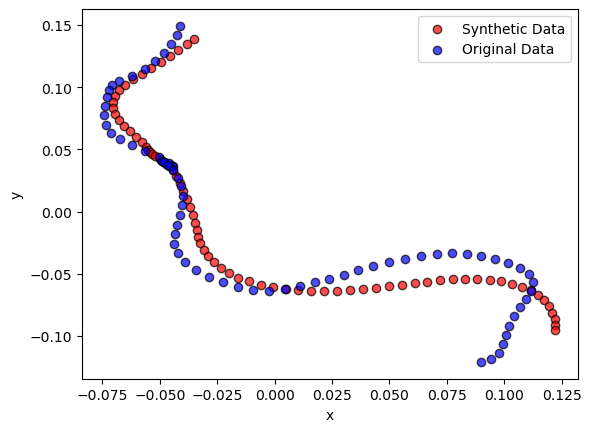

In [192]:
# 预处理数据
scaler = StandardScaler()
std_X = resampled_standardized_centerlines.reshape(curve_bs.shape[0], -1)
std_X_scaled = scaler.fit_transform(std_X)

# PCA 降维
std_PCA = PCA(n_components=10)
std_PCA_features = std_PCA.fit_transform(std_X_scaled)

# 计算 PCA 特征的均值和协方差
std_PCA_features_mean = np.mean(std_PCA_features, axis=0)
std_PCA_features_cov = np.cov(std_PCA_features, rowvar=False)

# 生成 1000 个符合原 PCA 特征分布的样本
synthetic_std_features = np.random.multivariate_normal(std_PCA_features_mean, std_PCA_features_cov * 0.6, size=1000)

# 逆 PCA 变换
synthetic_std_X_scaled = std_PCA.inverse_transform(synthetic_std_features)

# 逆标准化，使用 StandardScaler 的 mean_ 和 scale_
synthetic_std_X = synthetic_std_X_scaled * scaler.scale_ + scaler.mean_

# 还原成 (n, 75, 3) 形状
synthetic_std_centerlines = synthetic_std_X.reshape(1000, 75, 3)

# 可视化第一个生成的曲线与原始曲线对比
plt.scatter(synthetic_std_centerlines[0][:, 0], synthetic_std_centerlines[0][:, 1], label="Synthetic Data", alpha=0.7, c='r', edgecolors='k')
plt.scatter(resampled_standardized_centerlines[0][:, 0], resampled_standardized_centerlines[0][:, 1], label="Original Data", alpha=0.7, c='b', edgecolors='k')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()





synthetic_tortuosity = []
for i in range(len(synthetic_std_centerlines)):
    synthetic_tortuosity.append(calculate_curve_length(synthetic_std_centerlines[i])/np.linalg.norm(synthetic_std_centerlines[i][-1]-synthetic_std_centerlines[i][0]))
synthetic_tortuosity = np.array(synthetic_tortuosity)




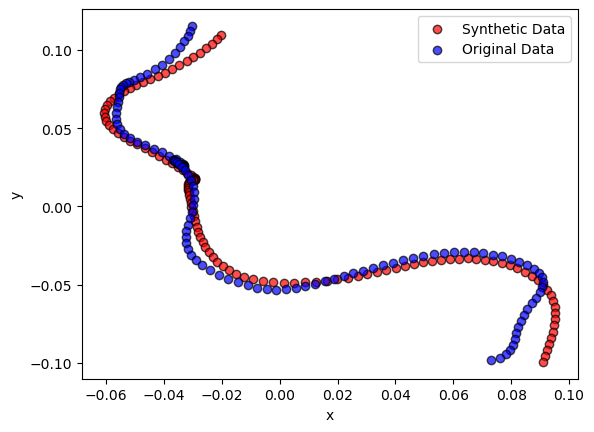

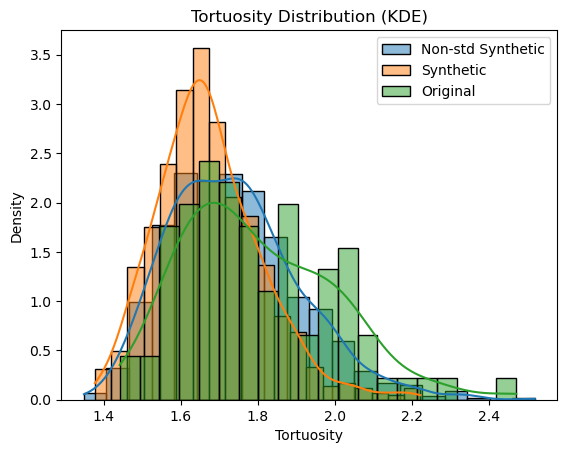

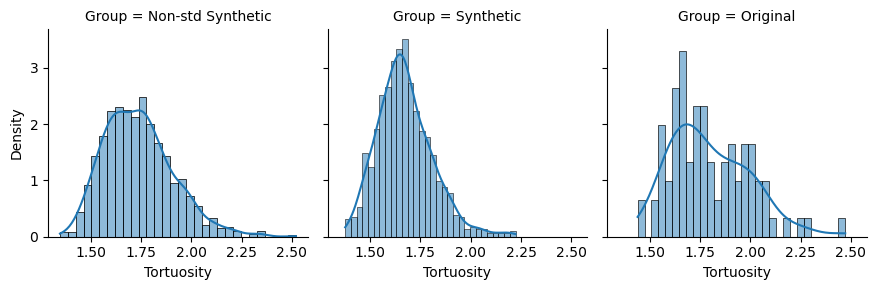

In [193]:
# 预处理数据
scaler = StandardScaler()
non_std_X = original_centerlines.reshape(curve_bs.shape[0], -1)
non_std_X_scaled = scaler.fit_transform(non_std_X)

# PCA 降维
non_std_PCA = PCA(n_components=10)
non_std_PCA_features = non_std_PCA.fit_transform(non_std_X_scaled)

# 计算 PCA 特征的均值和协方差
non_std_PCA_features_mean = np.mean(non_std_PCA_features, axis=0)
non_std_PCA_features_cov = np.cov(non_std_PCA_features, rowvar=False)

# 生成 1000 个符合原 PCA 特征分布的样本
synthetic_non_std_features = np.random.multivariate_normal(non_std_PCA_features_mean, non_std_PCA_features_cov * 1.0, size=1000)

# 逆 PCA 变换
synthetic_non_std_X_scaled = non_std_PCA.inverse_transform(synthetic_non_std_features)

# 逆标准化，使用 StandardScaler 的 mean_ 和 scale_
synthetic_non_std_X = synthetic_non_std_X_scaled * scaler.scale_ + scaler.mean_

# 还原成 (n, 75, 3) 形状
synthetic_non_std_centerlines = synthetic_non_std_X.reshape(1000, 120, 3)

# 可视化第一个生成的曲线与原始曲线对比
plt.scatter(synthetic_non_std_centerlines[0][:, 0], synthetic_non_std_centerlines[0][:, 1], label="Synthetic Data", alpha=0.7, c='r', edgecolors='k')
plt.scatter(original_centerlines[0][:, 0], original_centerlines[0][:, 1], label="Original Data", alpha=0.7, c='b', edgecolors='k')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


# 计算 original_tortuosities
non_std_synthetic_tortuosity = []
for i in range(len(synthetic_non_std_centerlines)):
    non_std_synthetic_tortuosity.append(calculate_curve_length(synthetic_non_std_centerlines[i]) / np.linalg.norm(synthetic_non_std_centerlines[i][-1] - synthetic_non_std_centerlines[i][0]))
non_std_synthetic_tortuosity = np.array(non_std_synthetic_tortuosity)

# 设置相同的bins
bins = np.linspace(
    min(non_std_synthetic_tortuosity.min(), synthetic_tortuosity.min(), original_tortuosities.min()),
    max(non_std_synthetic_tortuosity.max(), synthetic_tortuosity.max(), original_tortuosities.max()),
    20
)

# 计算每组数据在每个bin的频数
counts1, _ = np.histogram(non_std_synthetic_tortuosity, bins=bins)
counts2, _ = np.histogram(synthetic_tortuosity, bins=bins)
counts3, _ = np.histogram(original_tortuosities, bins=bins)

# 设置柱状图的宽度
bar_width = (bins[1] - bins[0]) * 0.3

sns.histplot(non_std_synthetic_tortuosity, kde=True, bins=20, stat='density', label='Non-std Synthetic')
sns.histplot(synthetic_tortuosity, kde=True, bins=20, stat='density', label='Synthetic')
sns.histplot(original_tortuosities, kde=True, bins=20, stat='density', label='Original')

plt.xlabel("Tortuosity")
plt.ylabel("Density")
plt.title("Tortuosity Distribution (KDE)")
plt.legend()
plt.show()

df = pd.DataFrame({
    'Tortuosity': np.concatenate([non_std_synthetic_tortuosity, synthetic_tortuosity, original_tortuosities]),
    'Group': (['Non-std Synthetic'] * len(non_std_synthetic_tortuosity) +
              ['Synthetic'] * len(synthetic_tortuosity) +
              ['Original'] * len(original_tortuosities))
})

g = sns.FacetGrid(df, col="Group", sharex=True, sharey=True)
g.map(sns.histplot, "Tortuosity", bins=30, stat='density', kde=True)

plt.show()

